# COVID-19 Dataset Analysis

Dataset: https://www.kaggle.com/datasets/meirnizri/covid19-dataset

## Import Libraries
This code imports necessary libraries and sets up a machine learning classification environment

In [1]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC


sns.set_theme(style="darkgrid")

## Loading and Previewing COVID-19 Data
This code loads a CSV file containing COVID-19 data and previews the first few rows of the data.

In [2]:
df = pd.read_csv("Covid Data.csv", engine="pyarrow")

df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


## Data Preprocessing and Feature Engineering
This code performs various data preprocessing and feature engineering tasks on the COVID-19 dataset.

In [3]:
df.isna().sum()

USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
DATE_DIED               0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
dtype: int64

In [4]:
print(f"Percentage of duplicates: {df.duplicated().sum() / len(df) * 100:.2f}%")

Percentage of duplicates: 77.44%


In [5]:
df["HAS_DIED"] = df["DATE_DIED"] != "9999-99-99"

In [6]:
df["CLASIFFICATION_FINAL"] = df["CLASIFFICATION_FINAL"] <= 3
df.rename(columns={"CLASIFFICATION_FINAL": "HAS_COVID"}, inplace=True)

In [7]:
df["HAS_COVID"].value_counts()

HAS_COVID
False    656596
True     391979
Name: count, dtype: int64

## Handling Missing Values in Boolean Columns
This code identifies and handles missing values in a list of boolean columns in the COVID-19 dataset.

In [8]:
boolean_columns = [
    "SEX",
    "PATIENT_TYPE",
    "PNEUMONIA",
    "PREGNANT",
    "DIABETES",
    "COPD",
    "ASTHMA",
    "INMSUPR",
    "HIPERTENSION",
    "CARDIOVASCULAR",
    "RENAL_CHRONIC",
    "OTHER_DISEASE",
    "OBESITY",
    "TOBACCO",
    "USMER",
    "INTUBED",
    "ICU",
]

most_missing_columns = []

for column in boolean_columns:

    missing_values = df[df[column].isin([97, 98, 99])][column]
    missing_values_percentage = missing_values.shape[0] / df.shape[0]

    print(f"Column: {column}")
    print(f"Max Value: {df[column].max()} | Min Value: {df[column].min()}")
    print(f"Missing Values Percentage: {missing_values_percentage:.3f}%")

    df[column] = df[column].replace(2, 0)

    if missing_values_percentage > 0.5:
        most_missing_columns.append(column)

    elif missing_values.shape[0] > 0:
        mode = df[~df[column].isin([97, 98, 99])][column].mode()[0]
        df[column] = df[column].replace([97, 98, 99], mode)
        print(f"Mode: {mode}")
        print("Missing values replaced with mode")

    print("------------------------------------------------------------------")

Column: SEX
Max Value: 2 | Min Value: 1
Missing Values Percentage: 0.000%
------------------------------------------------------------------
Column: PATIENT_TYPE
Max Value: 2 | Min Value: 1
Missing Values Percentage: 0.000%
------------------------------------------------------------------
Column: PNEUMONIA
Max Value: 99 | Min Value: 1
Missing Values Percentage: 0.015%
Mode: 0
Missing values replaced with mode
------------------------------------------------------------------
Column: PREGNANT
Max Value: 98 | Min Value: 1
Missing Values Percentage: 0.503%
------------------------------------------------------------------
Column: DIABETES
Max Value: 98 | Min Value: 1
Missing Values Percentage: 0.003%
Mode: 0
Missing values replaced with mode
------------------------------------------------------------------
Column: COPD
Max Value: 98 | Min Value: 1
Missing Values Percentage: 0.003%
Mode: 0
Missing values replaced with mode
-----------------------------------------------------------------

In [9]:
print(f"Columns with most missing values: {most_missing_columns}")

Columns with most missing values: ['PREGNANT', 'INTUBED', 'ICU']


## Handling Inconsistent Data
This code cleans missing values in the `PREGNANT` column for males (`SEX=0`) by replacing them with 0.

In [10]:
print(f"Men Pregnant Values Count:\n{df[df['SEX'] == 0]['PREGNANT'].value_counts()}")
df.loc[df["SEX"] == 0, "PREGNANT"] = 0

Men Pregnant Values Count:
PREGNANT
97    523511
Name: count, dtype: int64


This code analyzes the distribution of `PREGNANT` values for females (`SEX=1`) and imputes missing values using the mode (most frequent value).

In [11]:
print(f"Women Pregnant Values Count:\n{df[df['SEX'] == 1]['PREGNANT'].value_counts()}")
print(f"Filling missing values with mode: 0")
df.loc[df["SEX"] == 1, "PREGNANT"] = df.loc[df["SEX"] == 1, "PREGNANT"].replace(98, 0)

Women Pregnant Values Count:
PREGNANT
0     513179
1       8131
98      3754
Name: count, dtype: int64
Filling missing values with mode: 0


This code cleans missing values in the `ICU` column for "Returned Home" patients (`PATIENT_TYPE=1`) by replacing them with 0. Because the patients returned home, they likely wouldn't be in the ICU.

In [12]:
print(
    f"Returned Home Patients ICU Values Count:\n{df[df['PATIENT_TYPE'] == 1]['ICU'].value_counts()}"
)
df.loc[df["PATIENT_TYPE"] == 1, "ICU"] = 0

Returned Home Patients ICU Values Count:
ICU
97    848544
Name: count, dtype: int64


This code analyzes the distribution of `ICU` values for "Hospitalized" patients (`PATIENT_TYPE=0`) and imputes missing values using the mode (most frequent value).

In [13]:
print(
    f"Hospitalized Patients ICU Values Count:\n{df[df['PATIENT_TYPE'] == 0]['ICU'].value_counts()}"
)
print(f"Filling missing values with mode: 0")
df.loc[df["PATIENT_TYPE"] == 0, "ICU"] = df.loc[df["PATIENT_TYPE"] == 0, "ICU"].replace(
    99, 0
)

Hospitalized Patients ICU Values Count:
ICU
0     175685
1      16858
99      7488
Name: count, dtype: int64
Filling missing values with mode: 0


This code cleans missing values in the `INTUBED` column for "Returned Home" patients (`PATIENT_TYPE=1`) by replacing them with 0.

In [14]:
print(
    f"Returned Home Patients INTUBED Values Count:\n{df[df['PATIENT_TYPE'] == 1]['INTUBED'].value_counts()}"
)
df.loc[df["PATIENT_TYPE"] == 1, "INTUBED"] = 0

Returned Home Patients INTUBED Values Count:
INTUBED
97    848544
Name: count, dtype: int64


This code analyzes the distribution of `INTUBED` values for "Hospitalized" patients (`PATIENT_TYPE=0`) and imputes missing values using the mode (most frequent value).

In [15]:
print(
    f"Hospitalized Patients INTUBED Values Count:\n{df[df['PATIENT_TYPE'] == 0]['INTUBED'].value_counts()}"
)
print(f"Filling missing values with mode: 0")
df.loc[df["PATIENT_TYPE"] == 0, "INTUBED"] = df.loc[
    df["PATIENT_TYPE"] == 0, "INTUBED"
].replace(99, 0)

Hospitalized Patients INTUBED Values Count:
INTUBED
0     159050
1      33656
99      7325
Name: count, dtype: int64
Filling missing values with mode: 0


In [16]:
df.isna().sum()

USMER             0
MEDICAL_UNIT      0
SEX               0
PATIENT_TYPE      0
DATE_DIED         0
INTUBED           0
PNEUMONIA         0
AGE               0
PREGNANT          0
DIABETES          0
COPD              0
ASTHMA            0
INMSUPR           0
HIPERTENSION      0
OTHER_DISEASE     0
CARDIOVASCULAR    0
OBESITY           0
RENAL_CHRONIC     0
TOBACCO           0
HAS_COVID         0
ICU               0
HAS_DIED          0
dtype: int64

## Visualizing Death Percentage
This code creates a bar chart to visualize the percentage of patients who have died (`HAS_DIED`) in the COVID-19 dataset.

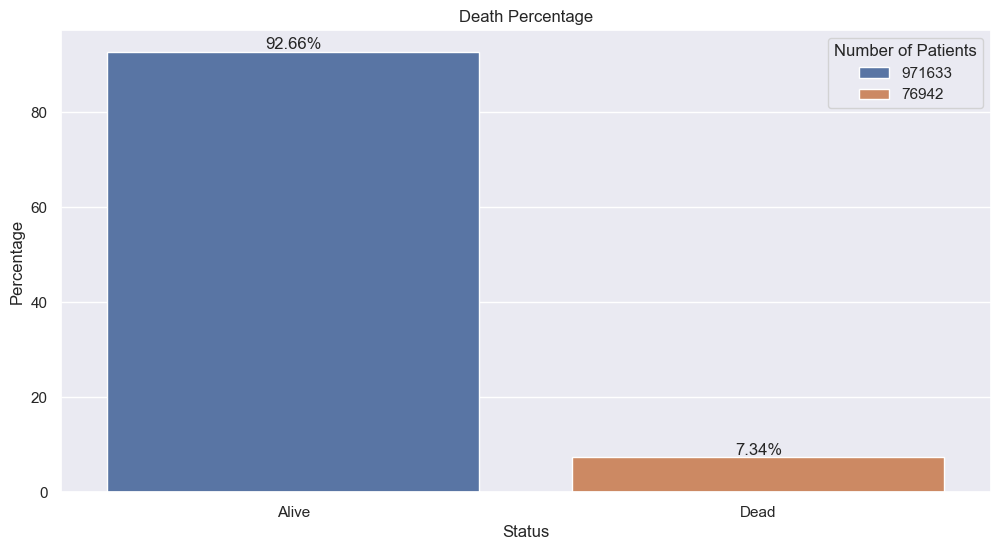

In [17]:
plt.figure(figsize=(12, 6))

ax = sns.countplot(data=df, x="HAS_DIED", stat="percent", hue="HAS_DIED", legend=False)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f%%")

plt.title("Death Percentage")
plt.xticks(ticks=[0, 1], labels=["Alive", "Dead"])
plt.xlabel("Status")
plt.ylabel("Percentage")
plt.legend(df["HAS_DIED"].value_counts(), title="Number of Patients")
plt.show()

## Visualizing COVID-19 Carriers among Deceased Patients
This code creates a pie chart to visualize the percentage of COVID-19 carriers among patients who have died (`HAS_DIED`) in the COVID-19 dataset.

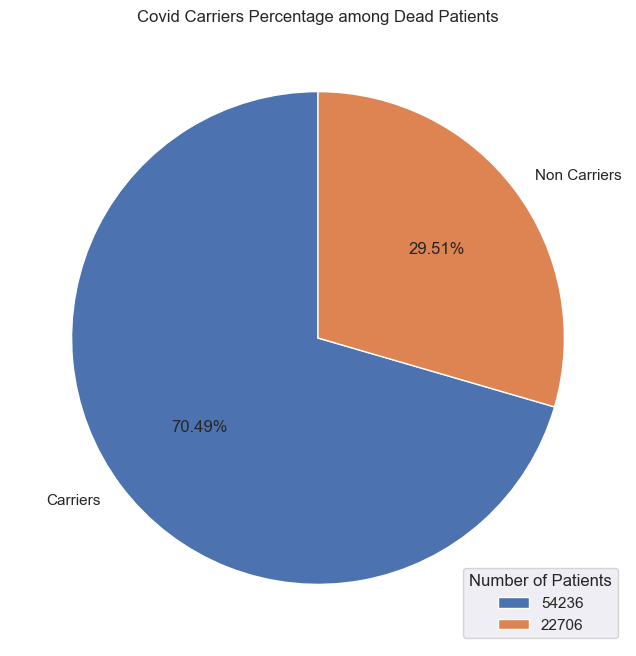

In [18]:
data = df[df["HAS_DIED"] == 1]["HAS_COVID"].value_counts()

plt.figure(figsize=(12, 8))


plt.pie(data, labels=["Carriers", "Non Carriers"], autopct="%1.2f%%", startangle=90)
plt.title("Covid Carriers Percentage among Dead Patients")
plt.legend(data, loc="lower right", title="Number of Patients")
plt.show()

## Visualizing Hospitalization Status among Deceased Patients
This code creates a pie chart to visualize the percentage of hospitalized patients among those who have died (`HAS_DIED`) in the COVID-19 dataset.

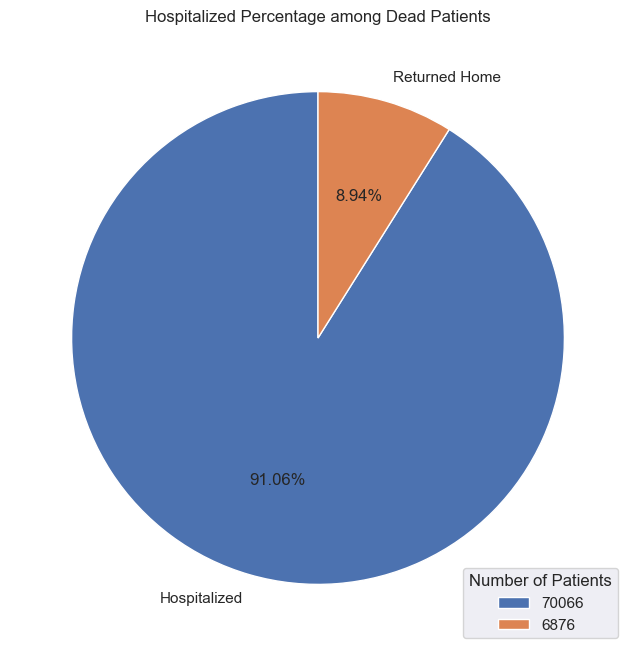

In [19]:
data = df[df["HAS_DIED"] == 1]["PATIENT_TYPE"].value_counts()

plt.figure(figsize=(12, 8))

plt.pie(
    data, labels=["Hospitalized", "Returned Home"], autopct="%1.2f%%", startangle=90
)
plt.title("Hospitalized Percentage among Dead Patients")
plt.legend(data, loc="lower right", title="Number of Patients")
plt.show()

## Analyzing Death Time Distribution
This code extracts and visualizes the distribution of death dates among patients who have died (`DATE_DIED`) in the COVID-19 dataset.

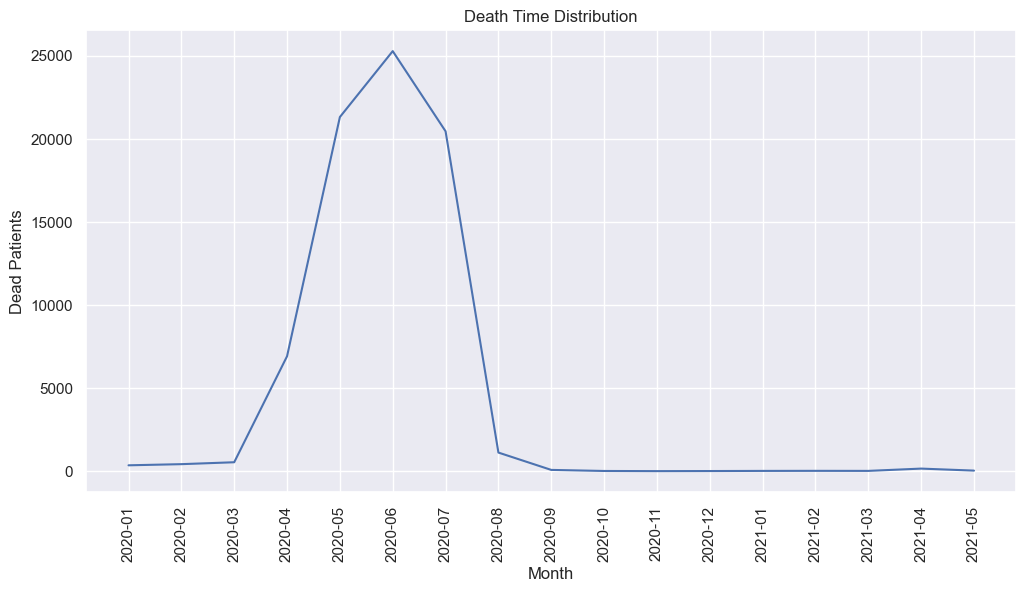

In [20]:
dead_patients = pd.to_datetime(
    df[df["DATE_DIED"] != "9999-99-99"]["DATE_DIED"], format="%d/%m/%Y"
)
dead_patients = dead_patients.dt.to_period("M")
dead_patients.value_counts().sort_index()

plt.figure(figsize=(12, 6))

sns.lineplot(
    x=dead_patients.value_counts().sort_index().index.astype(str),
    y=dead_patients.value_counts().sort_index().values,
)
plt.title("Death Time Distribution")
plt.xlabel("Month")
plt.ylabel("Dead Patients")
plt.xticks(rotation=90)
plt.show()

## Visualizing COVID-19 Carriers among All Patients
This code creates a bar chart to visualize the percentage of COVID-19 carriers among all patients in the dataset.

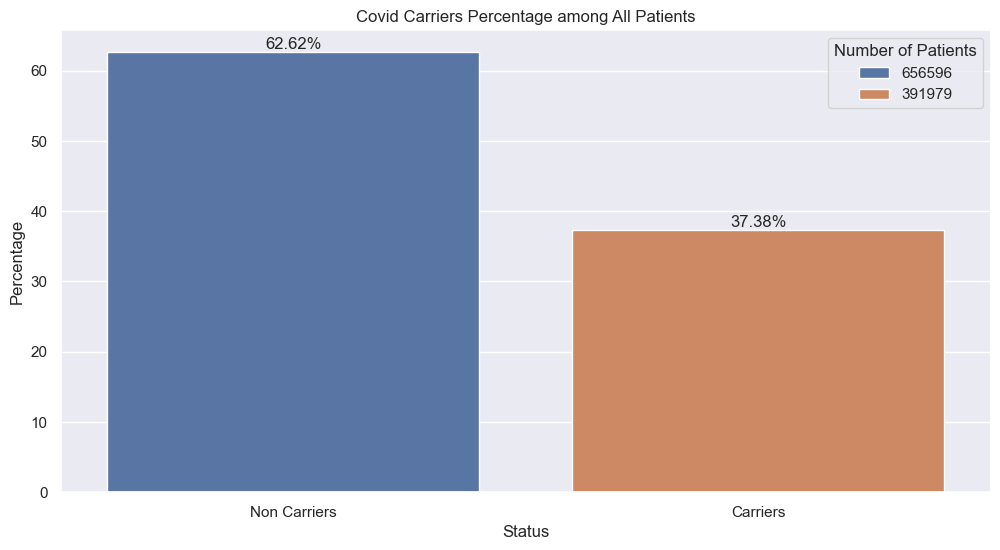

In [21]:
plt.figure(figsize=(12, 6))

ax = sns.countplot(data=df, x="HAS_COVID", stat="percent", hue="HAS_COVID")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f%%")

plt.title("Covid Carriers Percentage among All Patients")
plt.xticks(ticks=[0, 1], labels=["Non Carriers", "Carriers"])
plt.xlabel("Status")
plt.ylabel("Percentage")
plt.legend(df["HAS_COVID"].value_counts(), title="Number of Patients")
plt.show()

## Visualizing Death Percentage among COVID-19 Carriers
This code creates a pie chart to visualize the percentage of deaths among patients who have COVID-19 (`HAS_COVID`) in the dataset.

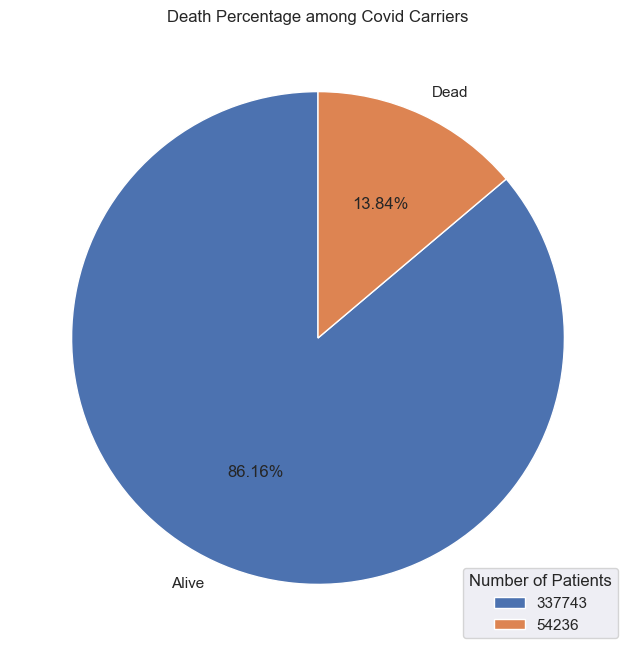

In [22]:
data = df[df["HAS_COVID"] == 1]["HAS_DIED"].value_counts()

plt.figure(figsize=(12, 8))

plt.pie(data, labels=["Alive", "Dead"], autopct="%1.2f%%", startangle=90)
plt.title("Death Percentage among Covid Carriers")
plt.legend(data, loc="lower right", title="Number of Patients")
plt.show()

## Visualizing the Distribution of Age
This code creates a histogram to visualize the distribution of ages in the dataset.

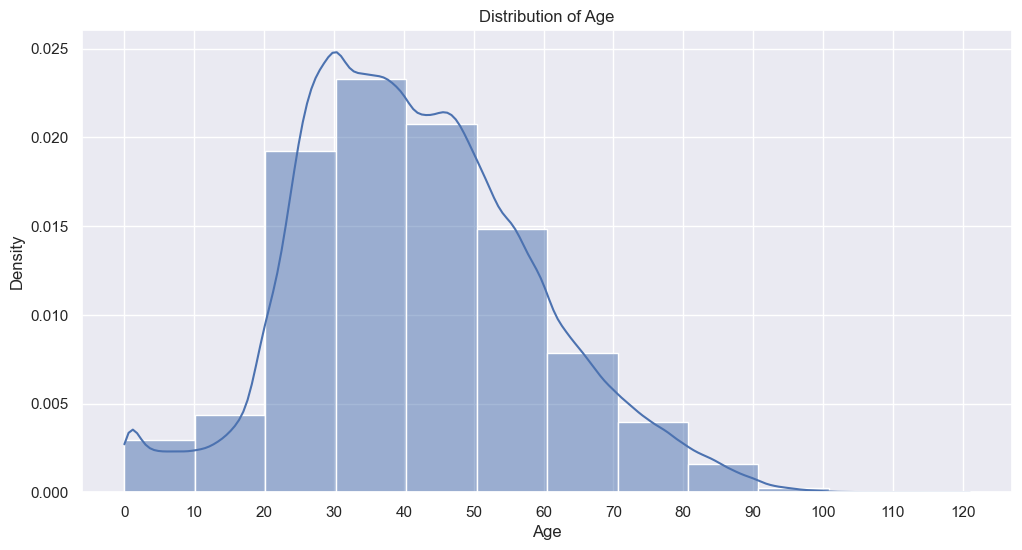

In [23]:
plt.figure(figsize=(12, 6))

bins = df["AGE"].max() // 10

ax = sns.histplot(data=df, x="AGE", kde=True, stat="density", bins=bins)
ax.xaxis.set_major_locator(plt.MultipleLocator(10))


plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()

## Visualizing COVID-19 Carriers by Age
This code creates a line plot to visualize the distribution of COVID-19 carriers by age in the dataset.

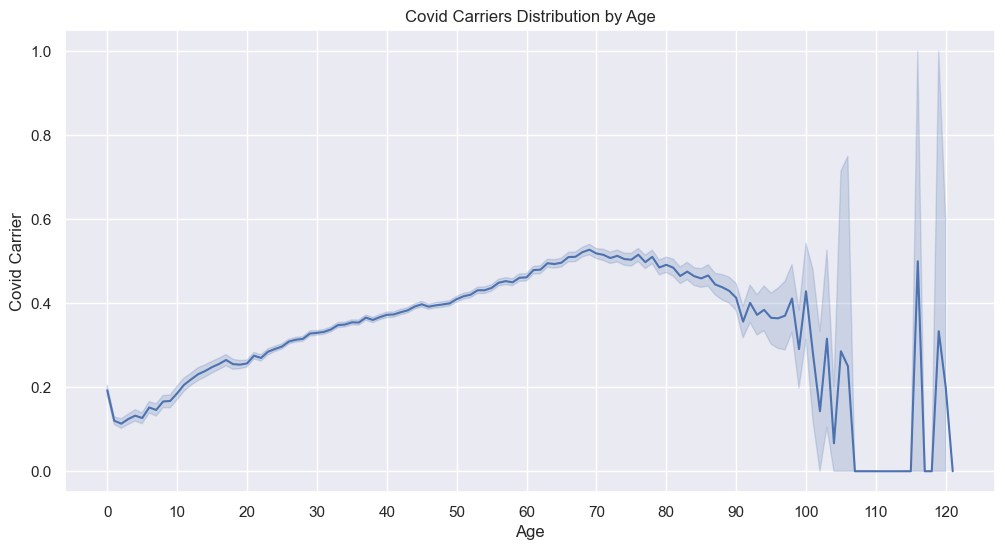

In [24]:
plt.figure(figsize=(12, 6))

ax = sns.lineplot(data=df, x="AGE", y="HAS_COVID")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))

plt.title("Covid Carriers Distribution by Age")
plt.xlabel("Age")
plt.ylabel("Covid Carrier")
plt.show()

## Visualizing Death Distribution by Age
This code creates a line plot to visualize the distribution of deaths by age in the dataset.

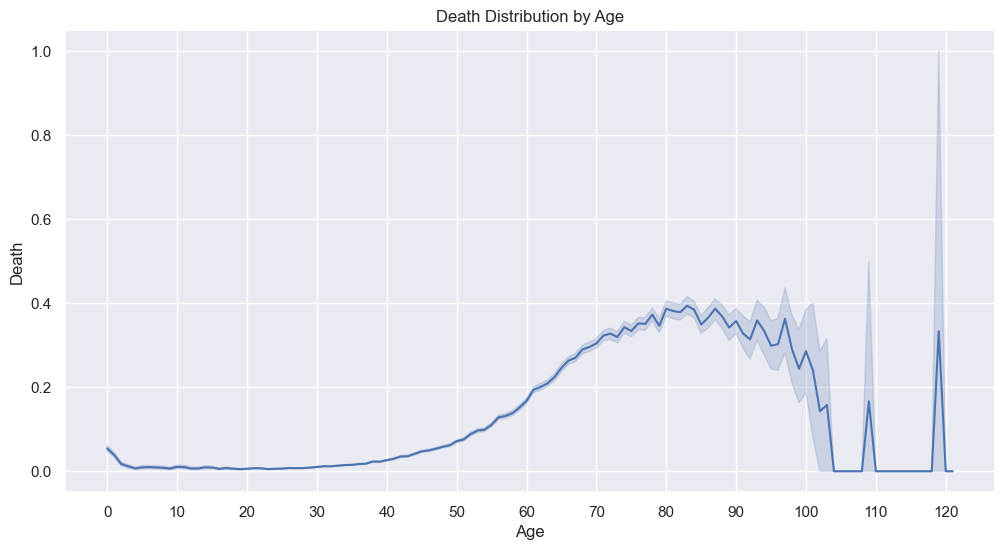

In [25]:
plt.figure(figsize=(12, 6))

ax = sns.lineplot(data=df, x="AGE", y="HAS_DIED")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))

plt.title("Death Distribution by Age")
plt.xlabel("Age")
plt.ylabel("Death")
plt.show()

## Visualizing the Distribution of Gender
This code creates a bar chart to visualize the distribution of gender in the dataset.

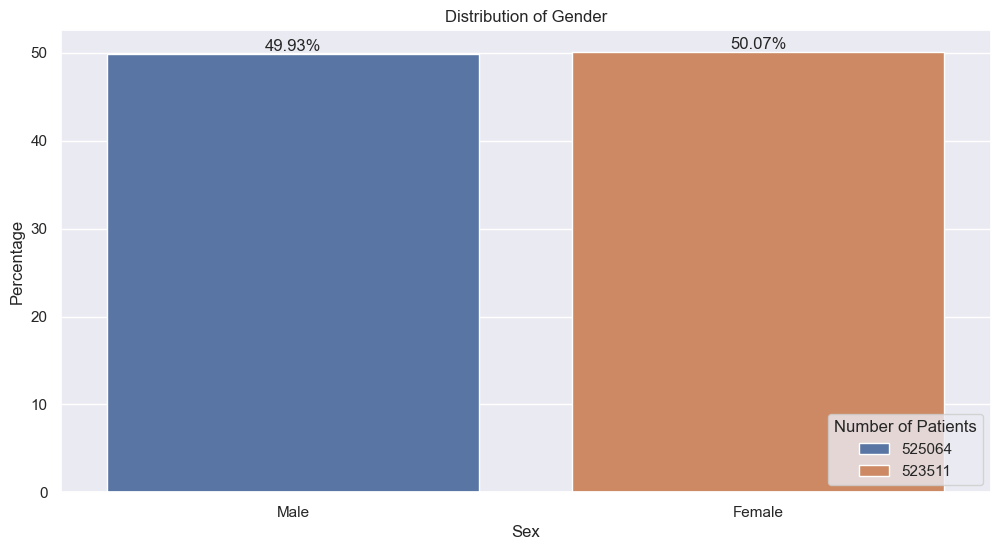

In [26]:
plt.figure(figsize=(12, 6))

ax = sns.countplot(data=df, x="SEX", stat="percent", hue="SEX")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f%%")

plt.title("Distribution of Gender")
plt.xlabel("Sex")
plt.xticks(ticks=[0, 1], labels=["Male", "Female"])
plt.ylabel("Percentage")
plt.legend(df["SEX"].value_counts(), title="Number of Patients", loc="lower right")
plt.show()

## Visualizing the Percentage of COVID-19 Carriers among Genders
This code creates a bar chart to visualize the percentage of COVID-19 carriers among males and females in the dataset.

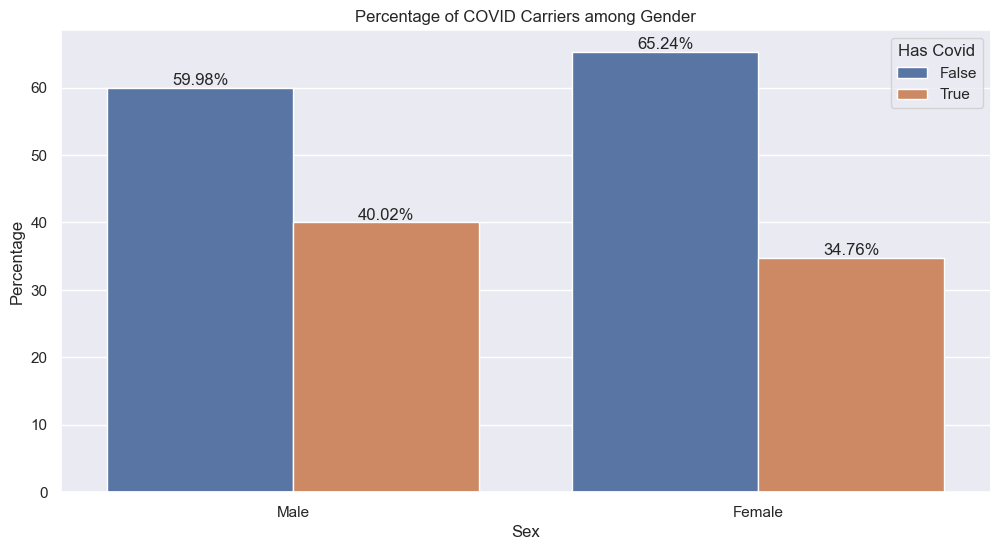

In [27]:
data = df.groupby("SEX")["HAS_COVID"].value_counts(normalize=True) * 100
data = data.reset_index(name="Percentage")
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=data, x="SEX", y="Percentage", hue="HAS_COVID")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f%%")

plt.title("Percentage of COVID Carriers among Gender")
plt.xlabel("Sex")
plt.xticks(ticks=[0, 1], labels=["Male", "Female"])
plt.ylabel("Percentage")
plt.legend(title="Has Covid")
plt.show()

## Visualizing the Percentage of Death among Genders
This code creates a bar chart to visualize the percentage of deaths among males and females in the dataset.

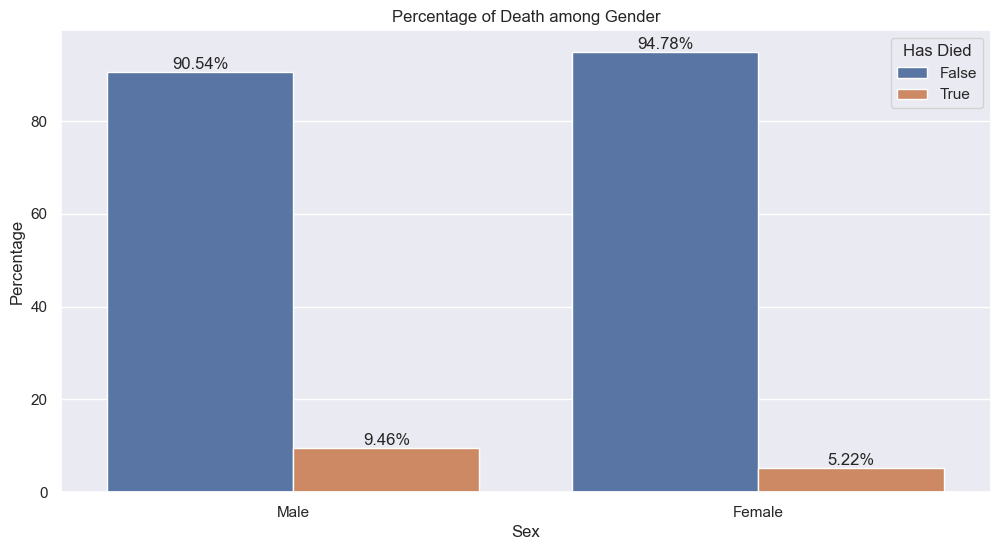

In [28]:
data = df.groupby("SEX")["HAS_DIED"].value_counts(normalize=True) * 100
data = data.reset_index(name="Percentage")
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=data, x="SEX", y="Percentage", hue="HAS_DIED")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f%%")

plt.title("Percentage of Death among Gender")
plt.xlabel("Sex")
plt.xticks(ticks=[0, 1], labels=["Male", "Female"])
plt.ylabel("Percentage")
plt.legend(title="Has Died")
plt.show()

## Visualizing the Percentage of COVID-19 Carriers among Obese Patients
This code creates a bar chart to visualize the percentage of COVID-19 carriers among obese and non-obese patients in the dataset.

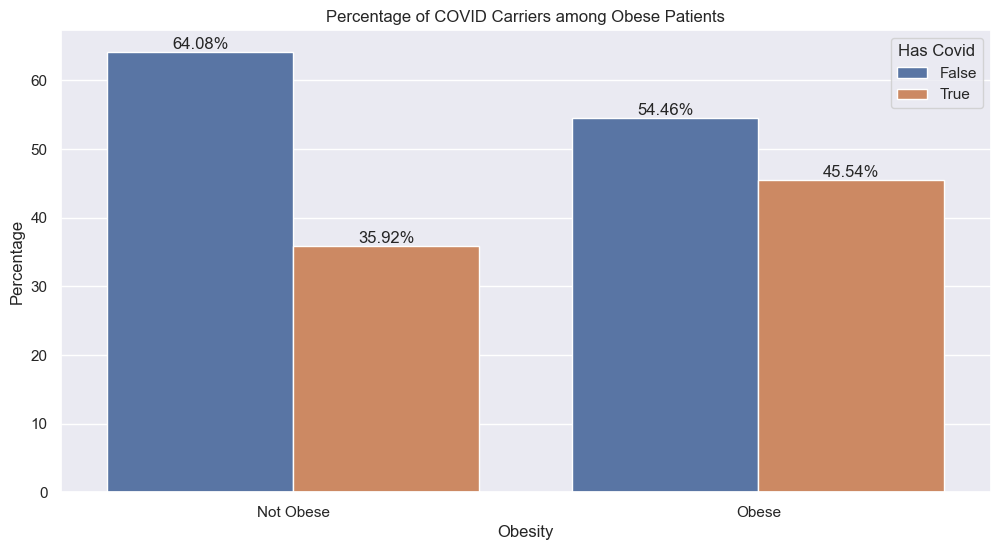

In [29]:
data = df.groupby("OBESITY")["HAS_COVID"].value_counts(normalize=True) * 100
data = data.reset_index(name="Percentage")
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=data, x="OBESITY", y="Percentage", hue="HAS_COVID")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f%%")

plt.title("Percentage of COVID Carriers among Obese Patients")
plt.xlabel("Obesity")
plt.xticks(ticks=[0, 1], labels=["Not Obese", "Obese"])
plt.ylabel("Percentage")
plt.legend(title="Has Covid")
plt.show()

## Visualizing the Percentage of Patient Types
This code creates a bar chart to visualize the percentage of hospitalized and returned home patients in the dataset.

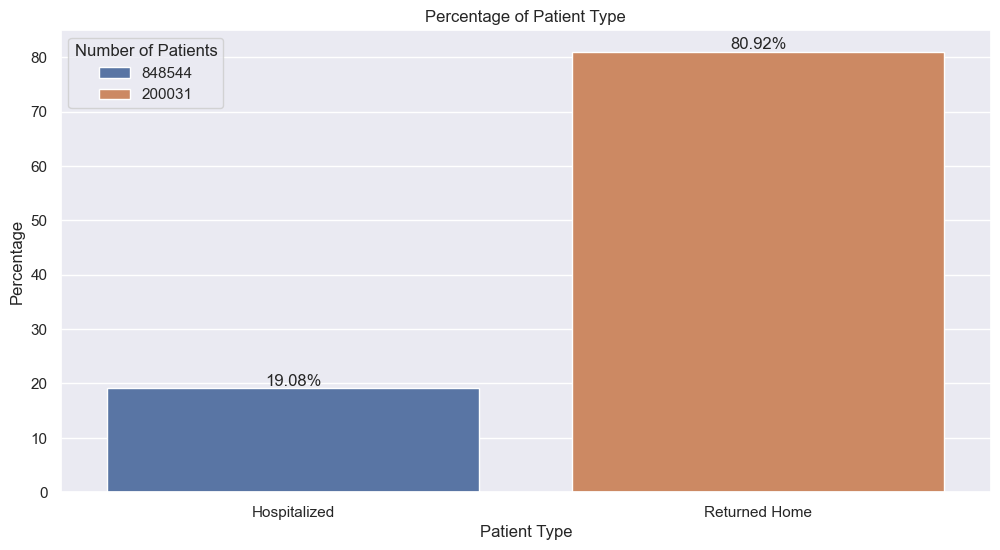

In [30]:
plt.figure(figsize=(12, 6))

ax = sns.countplot(
    data=df, x="PATIENT_TYPE", stat="percent", hue="PATIENT_TYPE", legend=False
)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f%%")

plt.title("Percentage of Patient Type")
plt.xlabel("Patient Type")
plt.xticks(ticks=[0, 1], labels=["Hospitalized", "Returned Home"])
plt.ylabel("Percentage")
plt.legend(df["PATIENT_TYPE"].value_counts(), title="Number of Patients")
plt.show()

## Visualizing Death Percentage among Hospitalized Patients
This code creates a pie chart to visualize the percentage of deaths among hospitalized patients in the dataset.

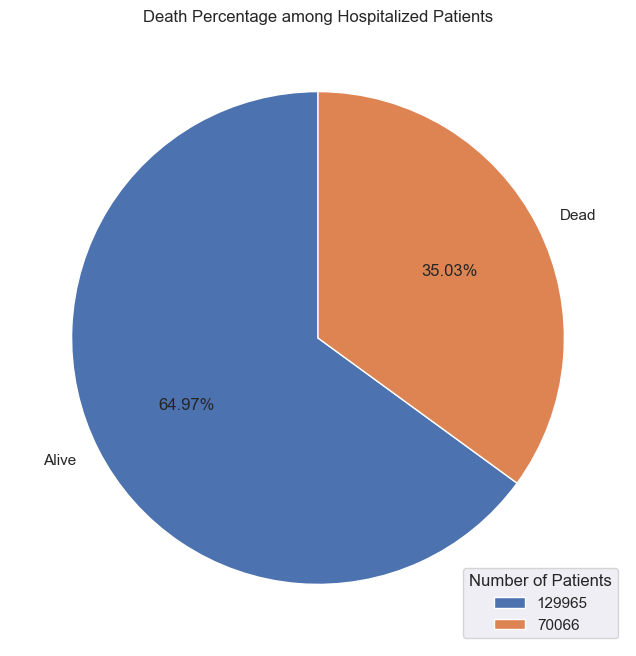

In [31]:
data = df[df["PATIENT_TYPE"] == 0]["HAS_DIED"].value_counts()

plt.figure(figsize=(12, 8))

plt.pie(data, labels=["Alive", "Dead"], autopct="%1.2f%%", startangle=90)
plt.title("Death Percentage among Hospitalized Patients")
plt.legend(data, loc="lower right", title="Number of Patients")
plt.show()

## Visualizing Death Percentage among ICU Patients
This code creates a pie chart to visualize the percentage of deaths among patients who were in the Intensive Care Unit (ICU) in the dataset.

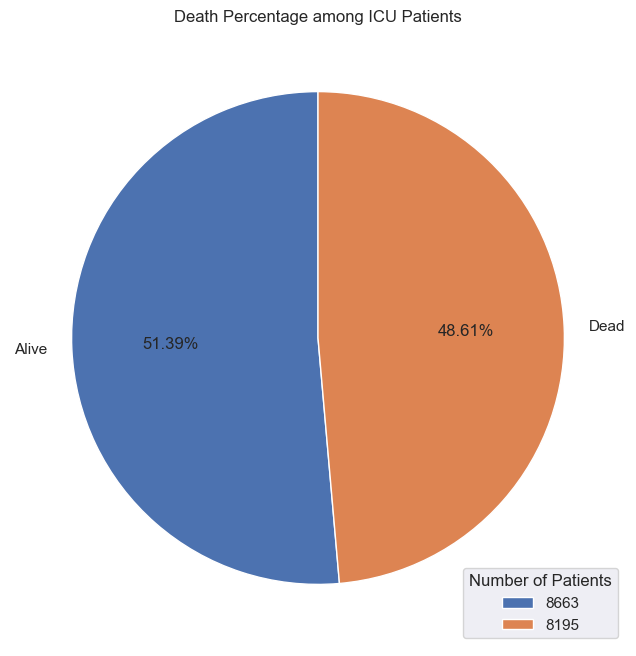

In [32]:
data = df[df["ICU"] == 1]["HAS_DIED"].value_counts()

plt.figure(figsize=(12, 8))

plt.pie(data, labels=["Alive", "Dead"], autopct="%1.2f%%", startangle=90)
plt.title("Death Percentage among ICU Patients")
plt.legend(data, loc="lower right", title="Number of Patients")
plt.show()

## Visualizing the Distribution of Comorbidities by Gender
This code creates a series of count plots to visualize the distribution of various comorbidities (e.g. tobacco use, renal chronic disease, COPD, etc.) by gender in the dataset.

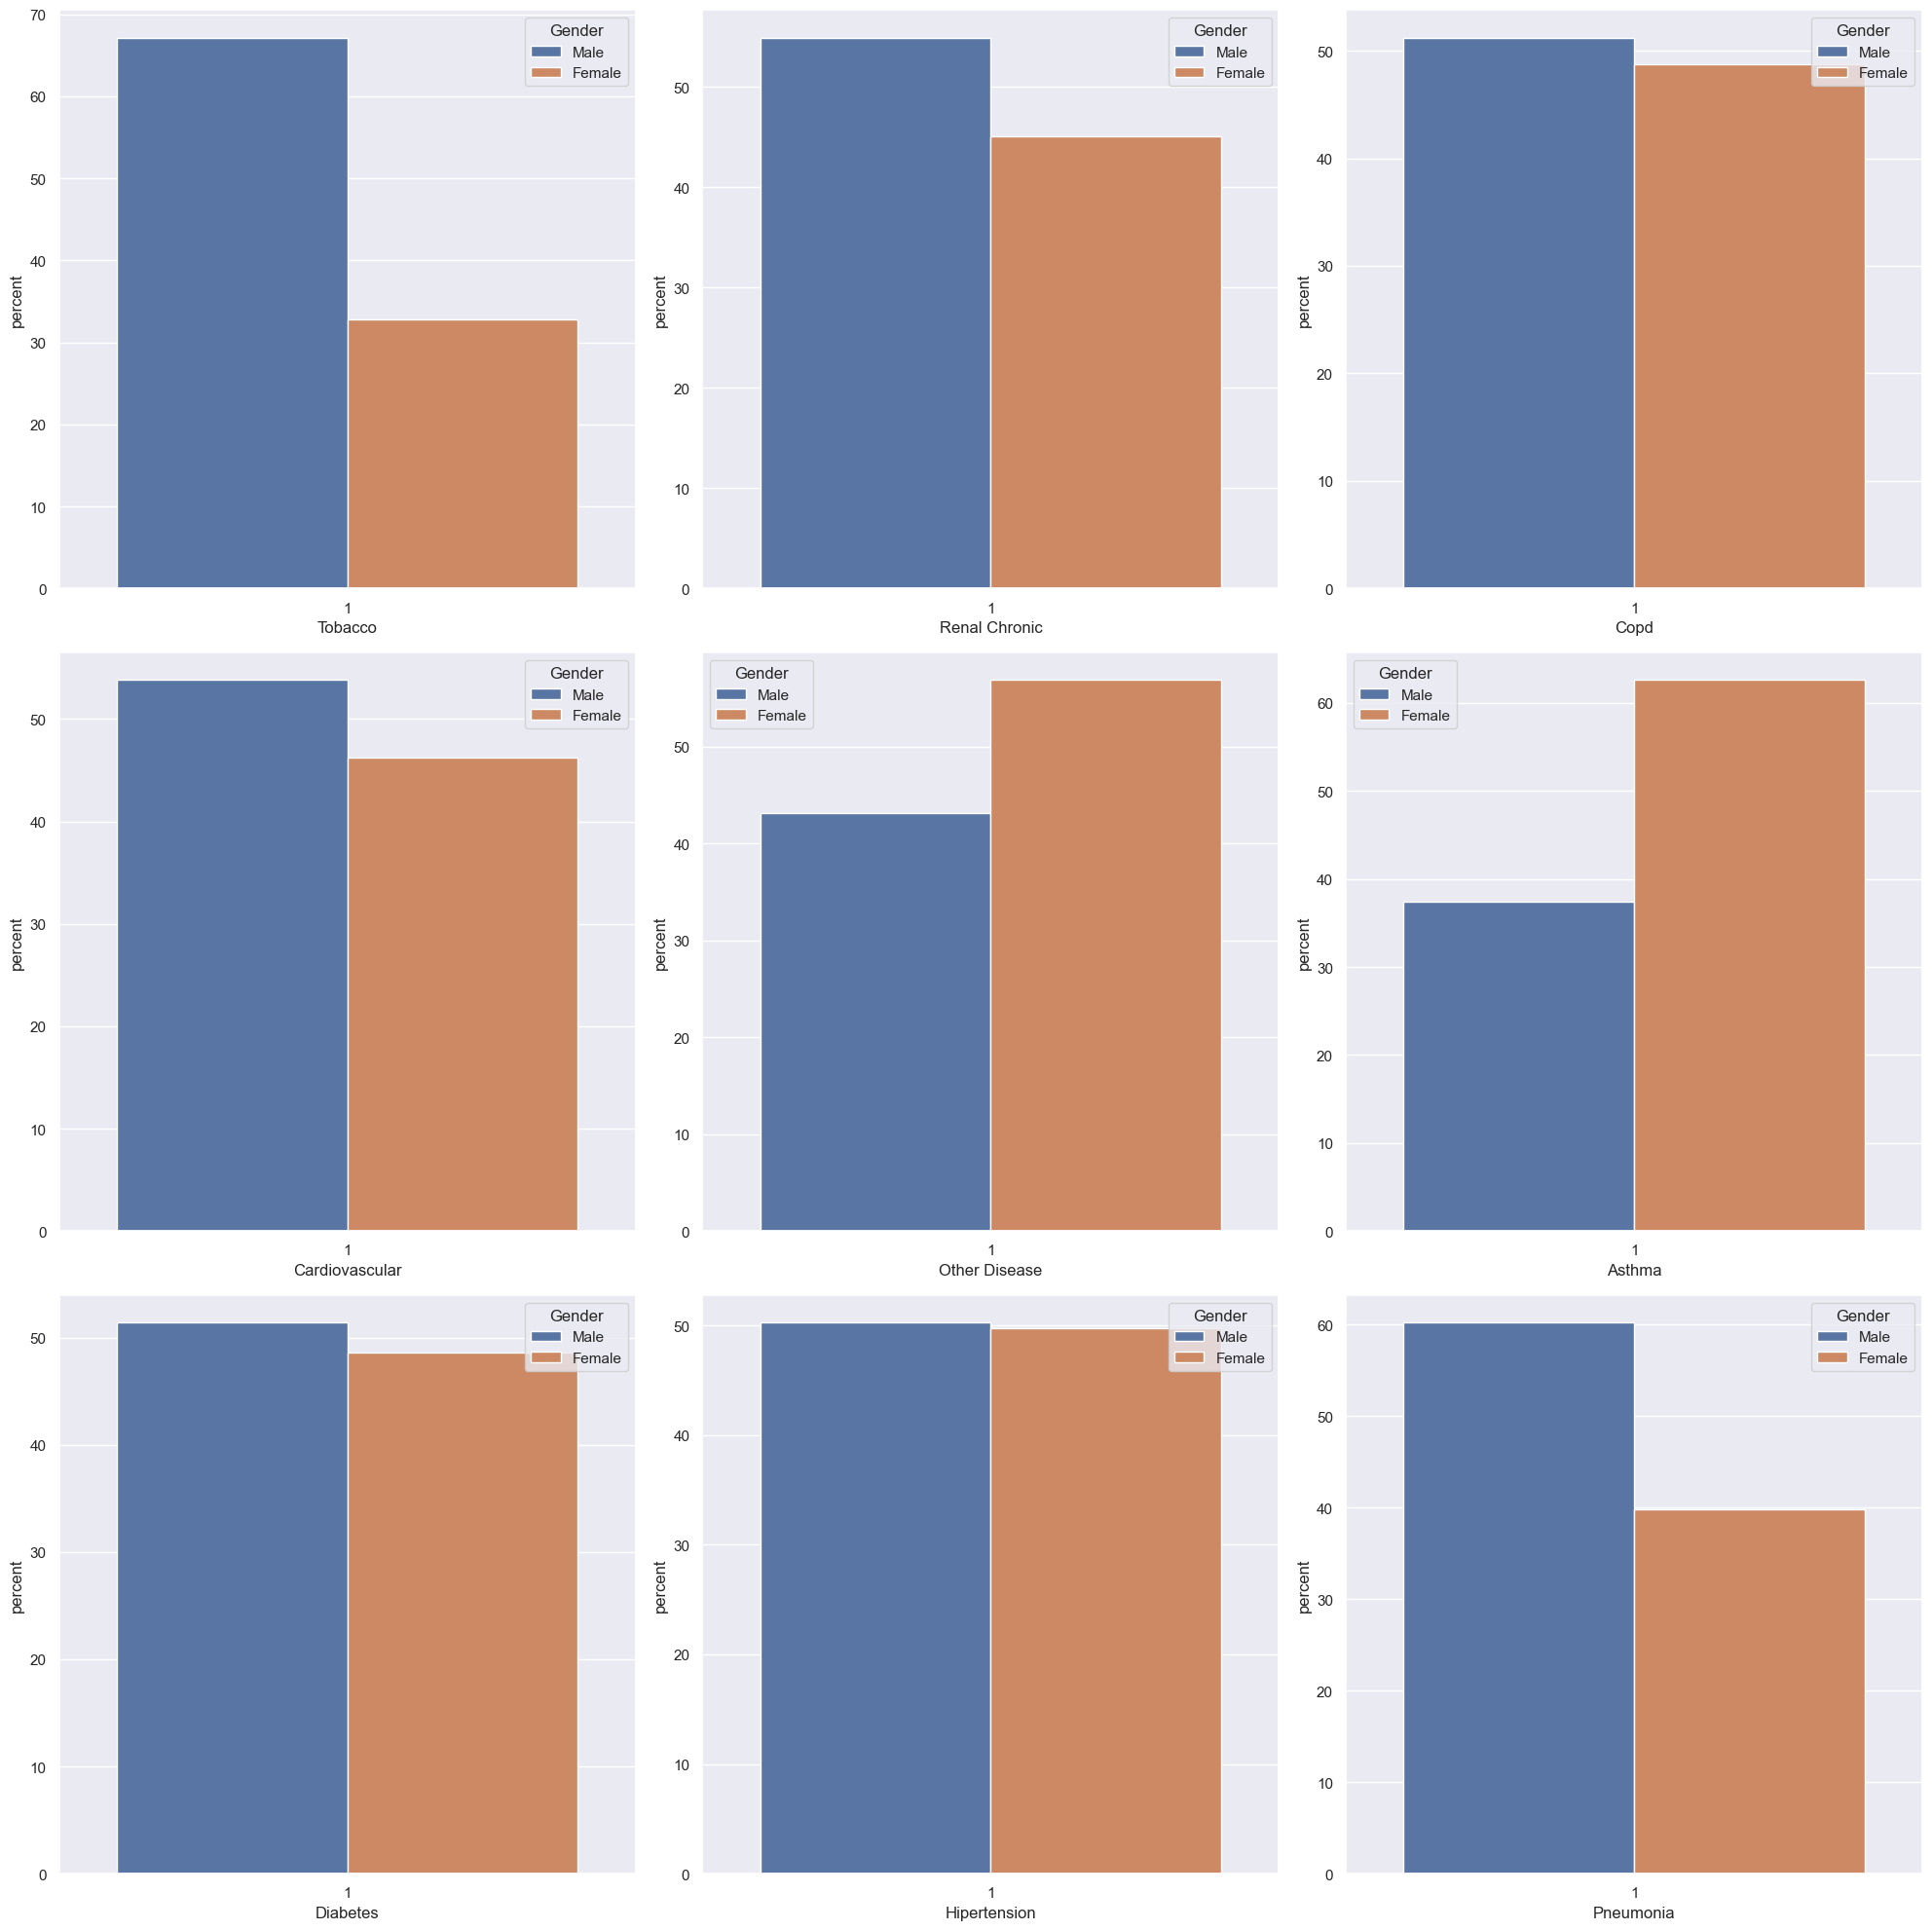

In [33]:
col = [
    "TOBACCO",
    "RENAL_CHRONIC",
    "COPD",
    "CARDIOVASCULAR",
    "OTHER_DISEASE",
    "ASTHMA",
    "DIABETES",
    "HIPERTENSION",
    "PNEUMONIA",
]

fig, axes = plt.subplots(3, 3, figsize=(20, 20))

for i, column in enumerate(col):
    ax = sns.countplot(
        data=df[df[column] == 1],
        x=column,
        hue="SEX",
        ax=axes[i // 3, i % 3],
        stat="percent",
    )
    ax.legend(title="Gender", labels=["Male", "Female"])
    ax.set_xlabel(column.title().replace("_", " "))

plt.tight_layout()
plt.show()

## Visualizing the Distribution of Comorbidities by COVID-19 Status
This code creates a series of count plots to visualize the distribution of various comorbidities (e.g. tobacco use, renal chronic disease, COPD, etc.) by COVID-19 status in the dataset.

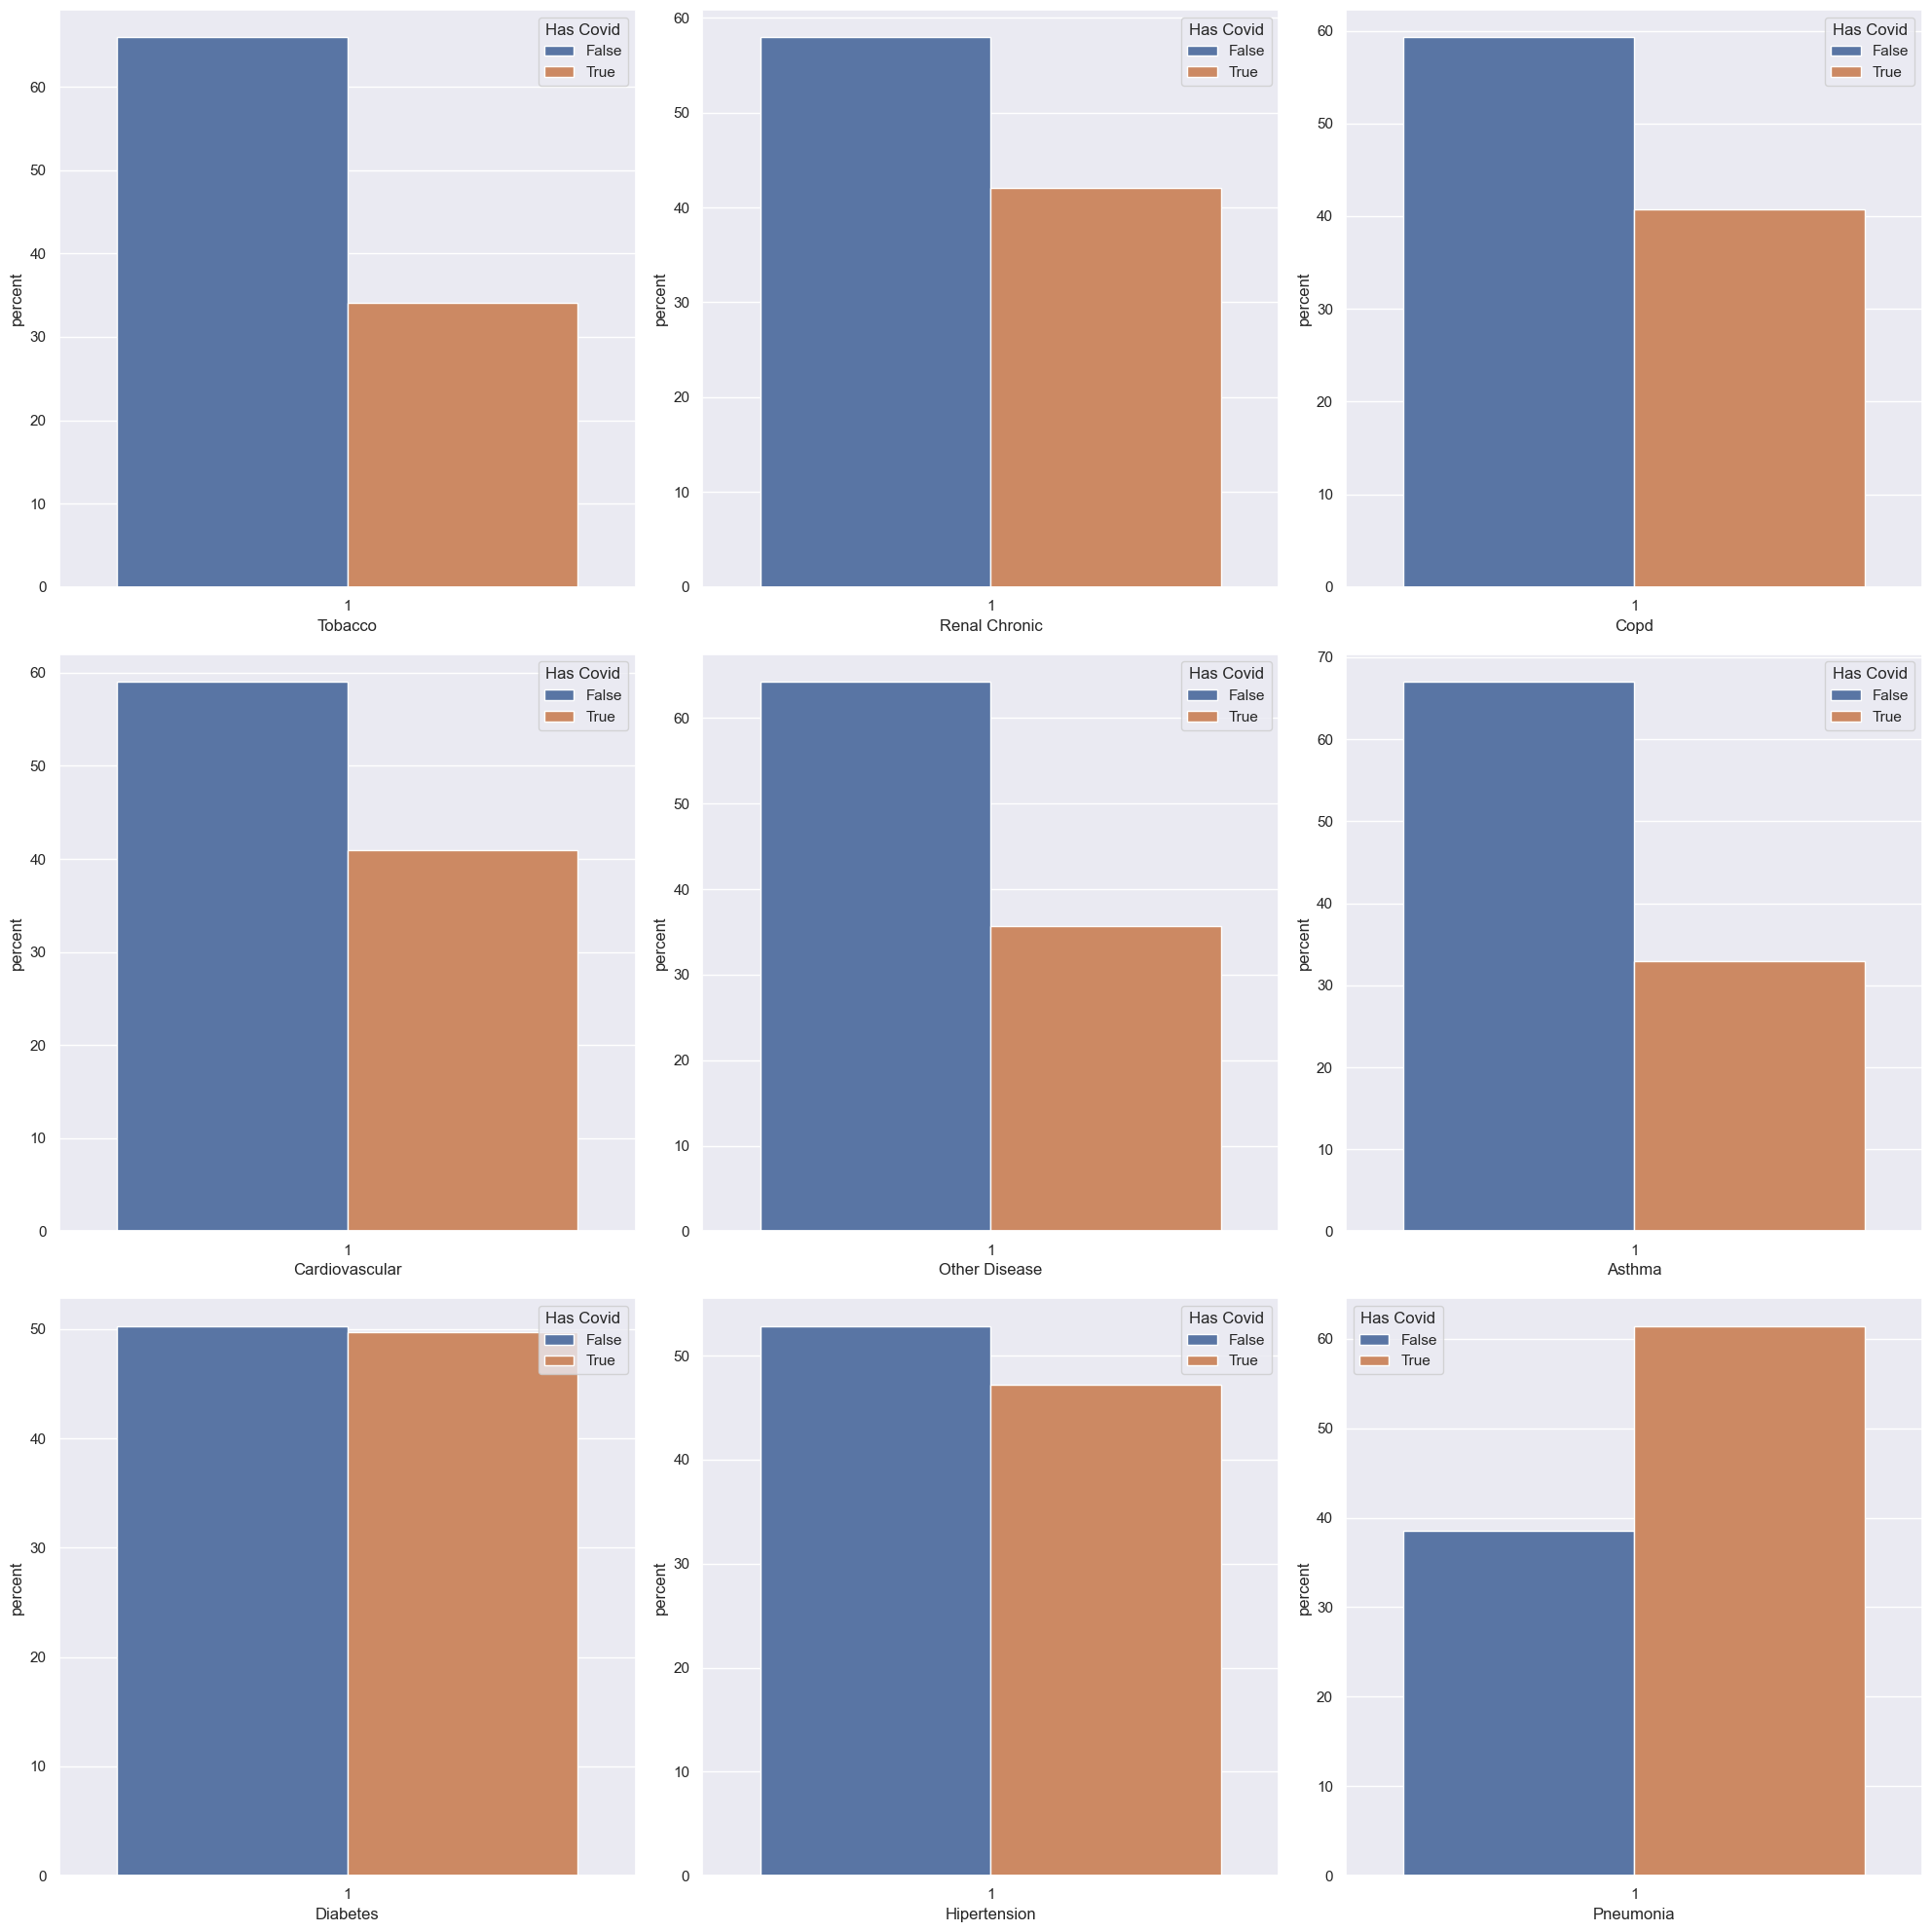

In [34]:
col = [
    "TOBACCO",
    "RENAL_CHRONIC",
    "COPD",
    "CARDIOVASCULAR",
    "OTHER_DISEASE",
    "ASTHMA",
    "DIABETES",
    "HIPERTENSION",
    "PNEUMONIA",
]

fig, axes = plt.subplots(3, 3, figsize=(20, 20))

for i, column in enumerate(col):
    ax = sns.countplot(
        data=df[df[column] == 1],
        x=column,
        hue="HAS_COVID",
        ax=axes[i // 3, i % 3],
        stat="percent",
    )
    ax.legend(title="Has Covid", labels=["False", "True"])
    ax.set_xlabel(column.title().replace("_", " "))

plt.tight_layout()
plt.show()

## Visualizing the Distribution of Comorbidities by Death Status
This code creates a series of count plots to visualize the distribution of various comorbidities (e.g. tobacco use, renal chronic disease, COPD, etc.) by death status in the dataset.

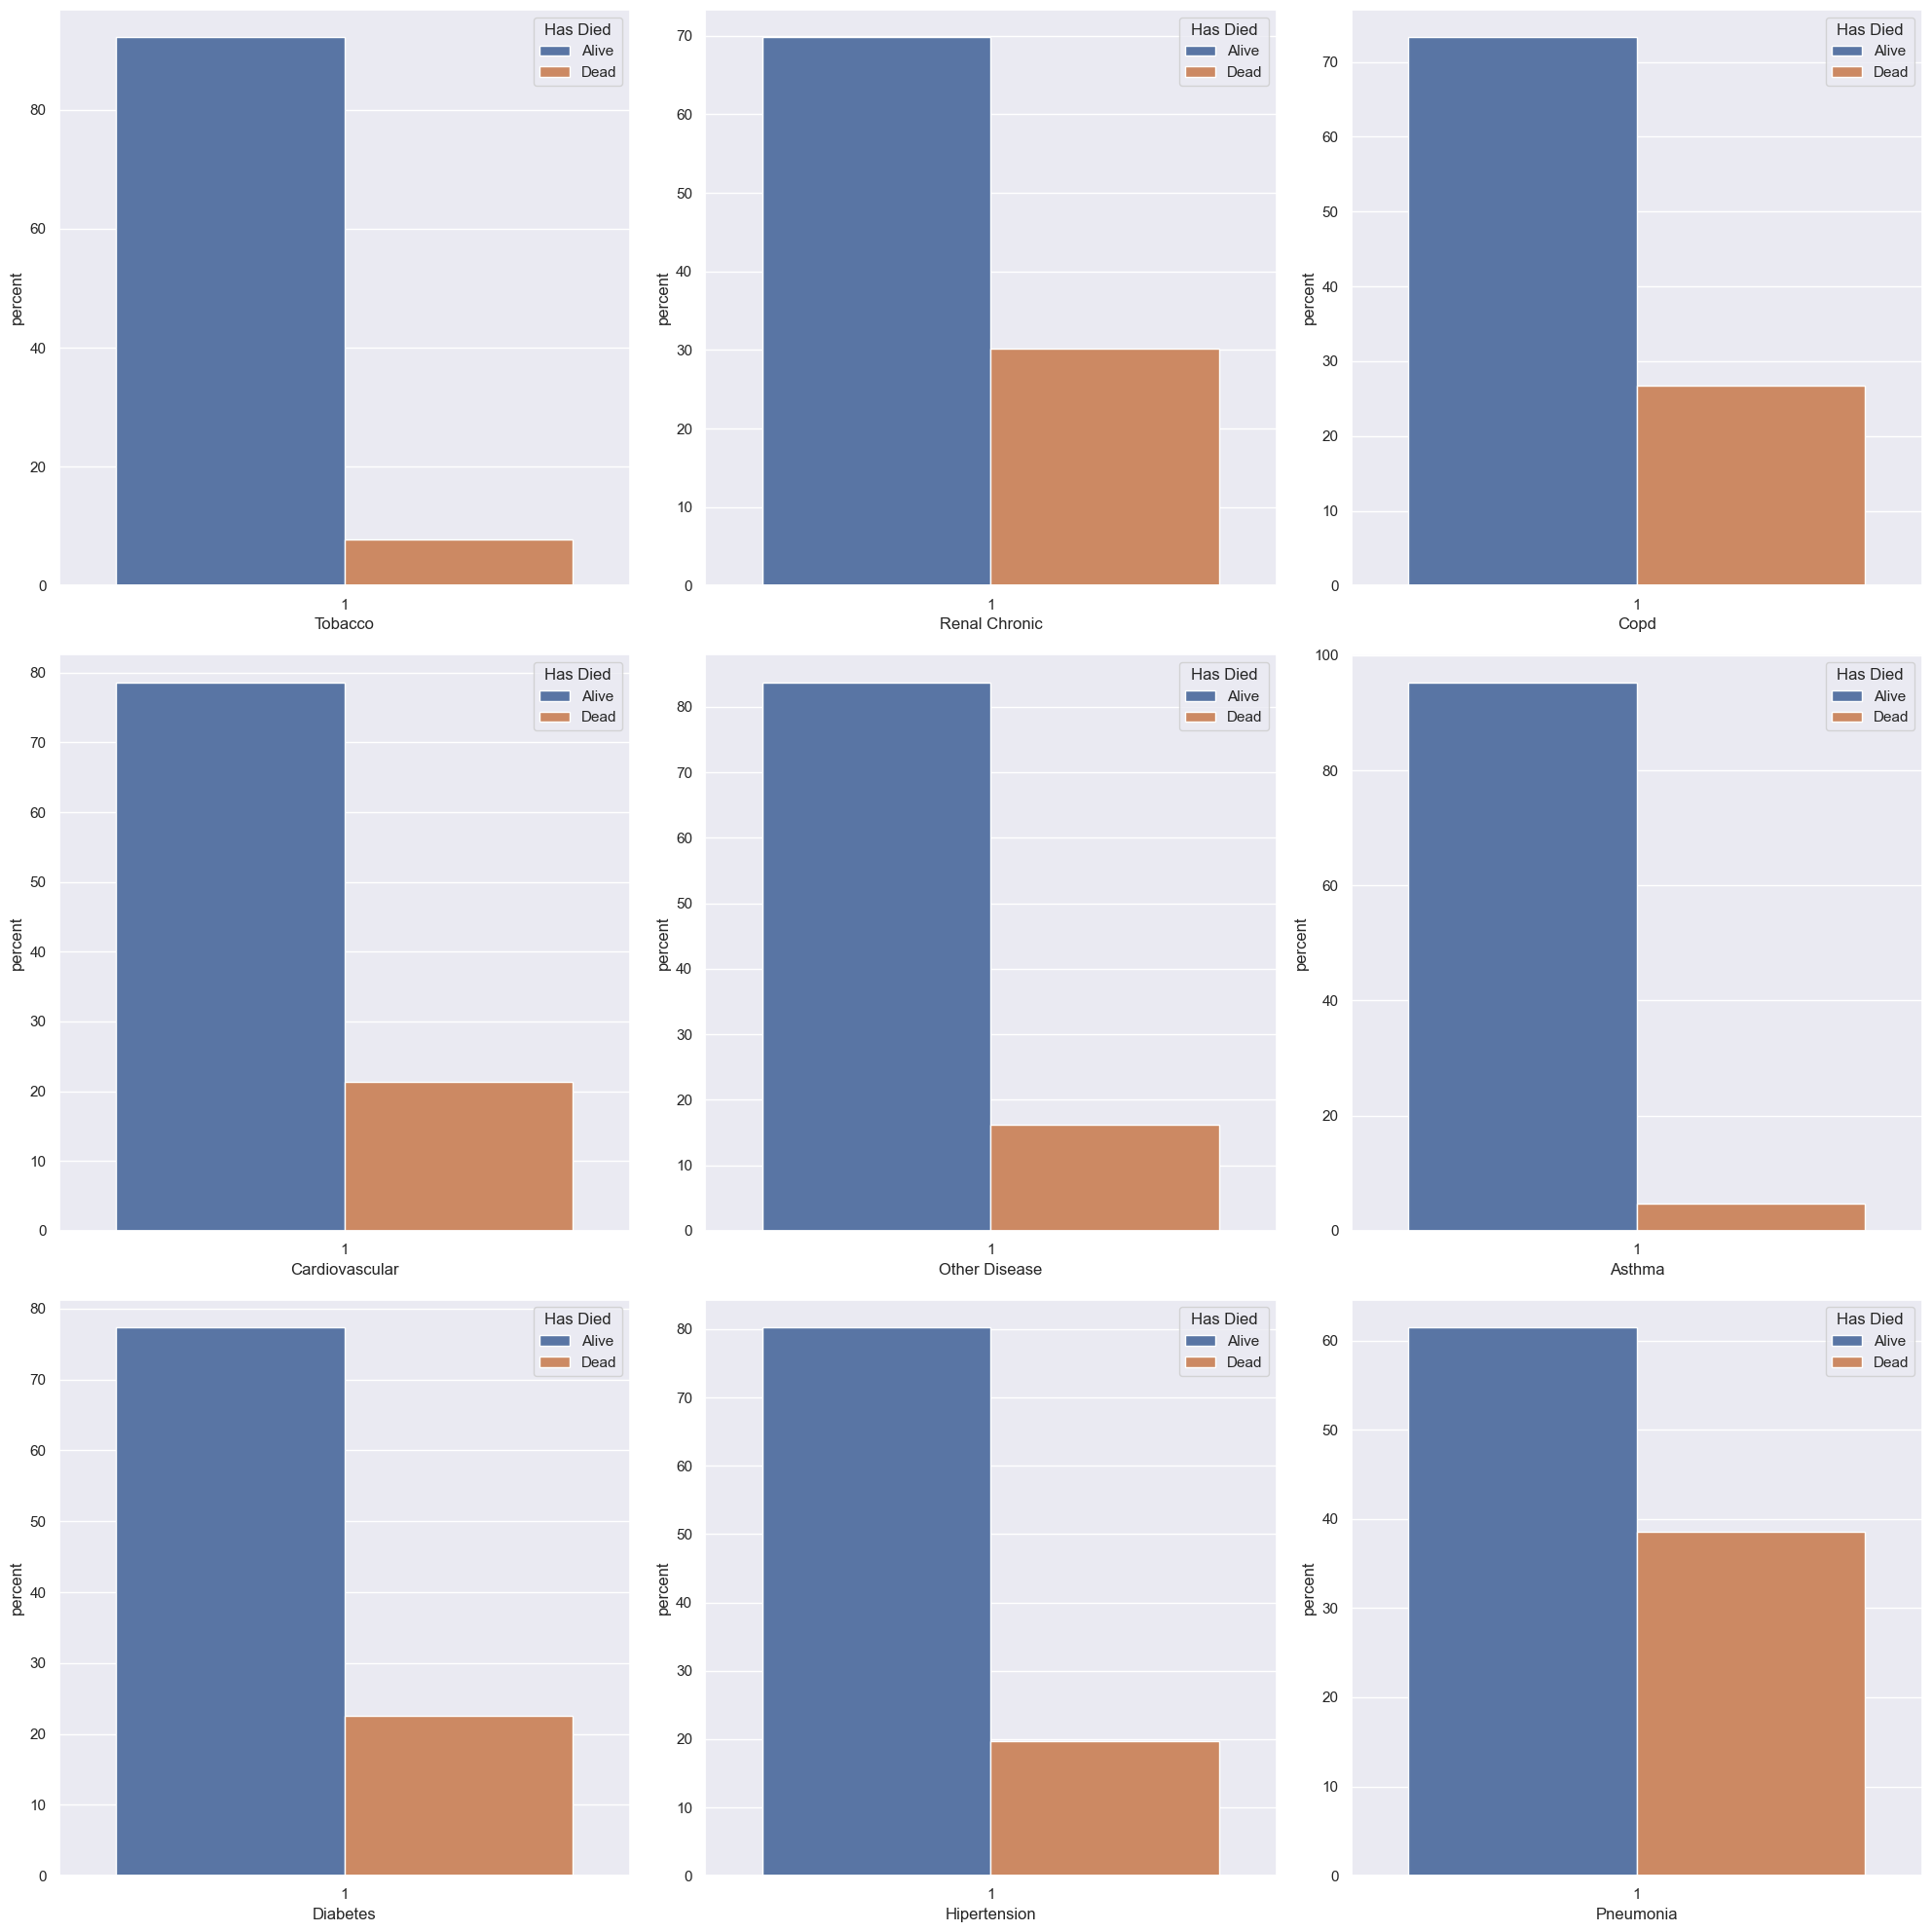

In [35]:
col = [
    "TOBACCO",
    "RENAL_CHRONIC",
    "COPD",
    "CARDIOVASCULAR",
    "OTHER_DISEASE",
    "ASTHMA",
    "DIABETES",
    "HIPERTENSION",
    "PNEUMONIA",
]

fig, axes = plt.subplots(3, 3, figsize=(20, 20))

for i, column in enumerate(col):
    ax = sns.countplot(
        data=df[df[column] == 1],
        x=column,
        hue="HAS_DIED",
        ax=axes[i // 3, i % 3],
        stat="percent",
    )
    ax.legend(title="Has Died", labels=["Alive", "Dead"])
    ax.set_xlabel(column.title().replace("_", " "))

plt.tight_layout()
plt.show()

# COVID-19 Dataset Prediction

This code removes the `DATE_DIED` column from the COVID-19 data. The `DATE_DIED` column is not relevant for the modeling tasks.

In [36]:
df.drop(columns=["DATE_DIED"], inplace=True)

## Visualizing Correlation Matrix
This code generates a correlation matrix heatmap to visualize the relationships between variables in the COVID-19 data.

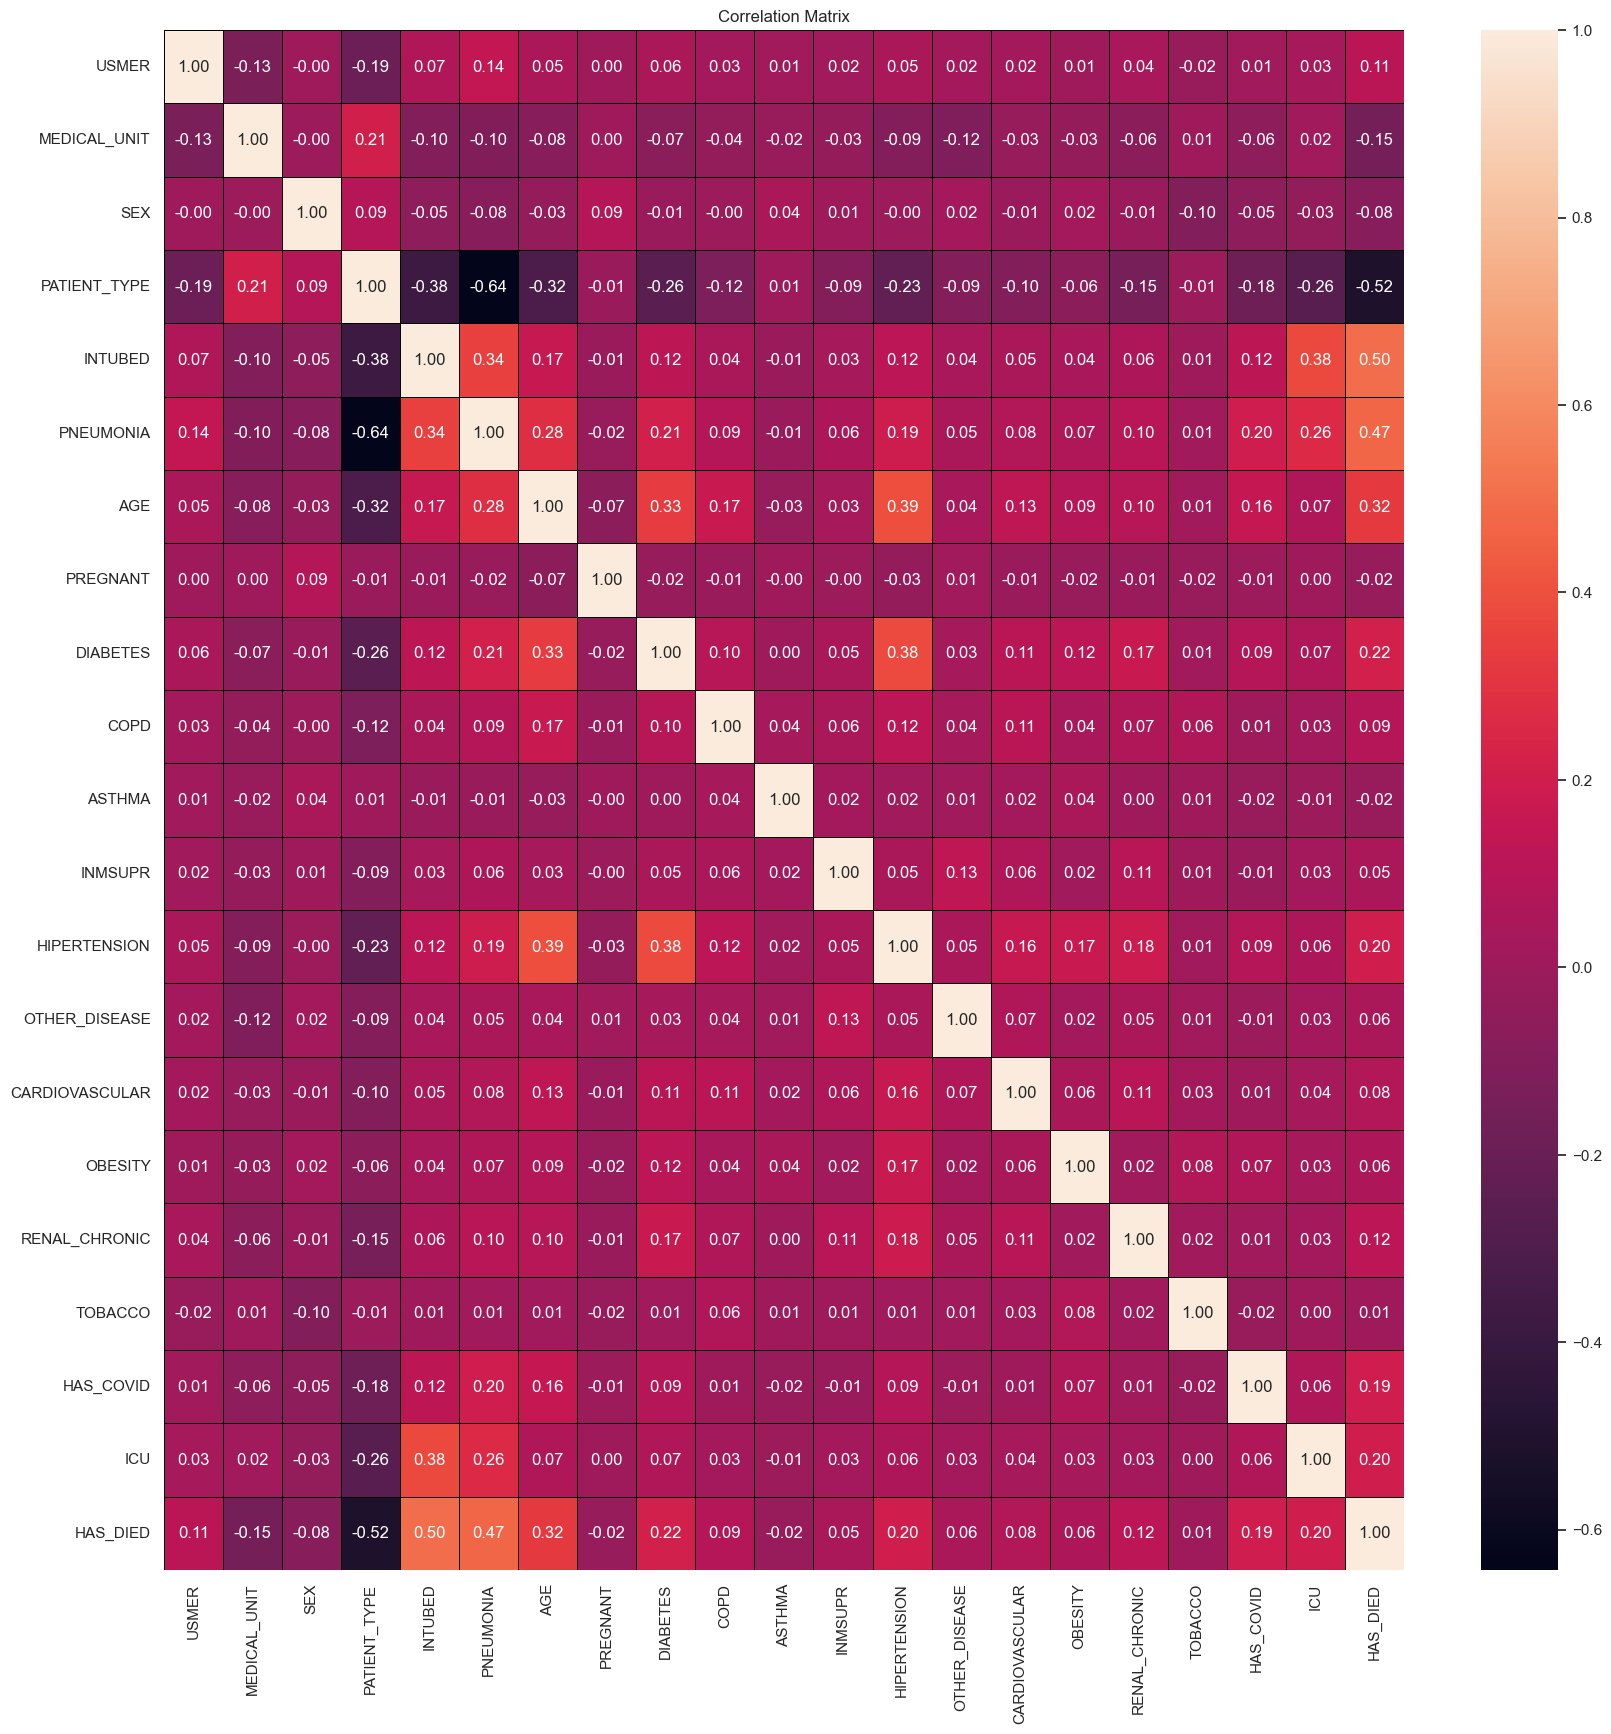

In [37]:
plt.figure(figsize=(20, 20))

sns.heatmap(df.corr(), annot=True, fmt=".2f", linewidths=0.5, linecolor="black")
plt.title("Correlation Matrix")
plt.show()

## Scaling the `AGE` Column
This code scales the `AGE` column of the COVID-19 data using the Standard Scaler from Scikit-learn. By scaling the `AGE` column, we ensure that it is on the same scale as other features in the dataset, which can improve the performance and accuracy of our machine learning models.

In [38]:
scaler = StandardScaler()

df["AGE"] = scaler.fit_transform(df[["AGE"]])

## Removing Duplicate Rows
This code removes duplicate rows from the COVID-19 data. By dropping duplicates, we can ensure that our dataset is clean and consistent, which is essential for reliable and accurate analysis and modeling.

In [39]:
df.drop_duplicates(inplace=True)

## Splitting Data into Training and Testing Sets
This code splits the COVID-19 data into training and testing sets using the `train_test_split` function from scikit-learn. By splitting the data into training and testing sets, we can ensure that our model is generalizing well and not just memorizing the training data.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["HAS_DIED"]), df["HAS_DIED"], test_size=0.2, random_state=42
)

## Visualizing Class Imbalance in Training Data
This code creates a count plot to visualize the class imbalance in the training data.

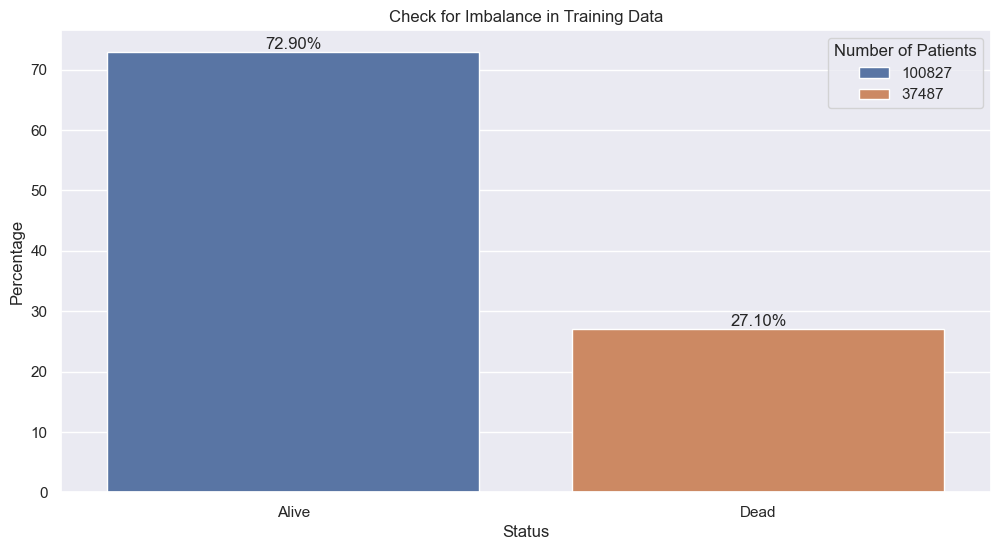

In [41]:
plt.figure(figsize=(12, 6))

ax = sns.countplot(x=y_train, stat="percent", hue=y_train, legend=False)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f%%")

plt.title("Check for Imbalance in Training Data")
plt.xticks(ticks=[0, 1], labels=["Alive", "Dead"])
plt.xlabel("Status")
plt.ylabel("Percentage")
plt.legend(y_train.value_counts(), title="Number of Patients")
plt.show()

## Applying SMOTE to Oversample Minority Class
This code applies the Synthetic Minority Over-sampling Technique (SMOTE) to the training data to oversample the minority class.

In [42]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

This plot provides a visual check for any class imbalance in the training data after SMOTE has been applied, ensuring that the data is appropriately balanced for subsequent modeling steps.

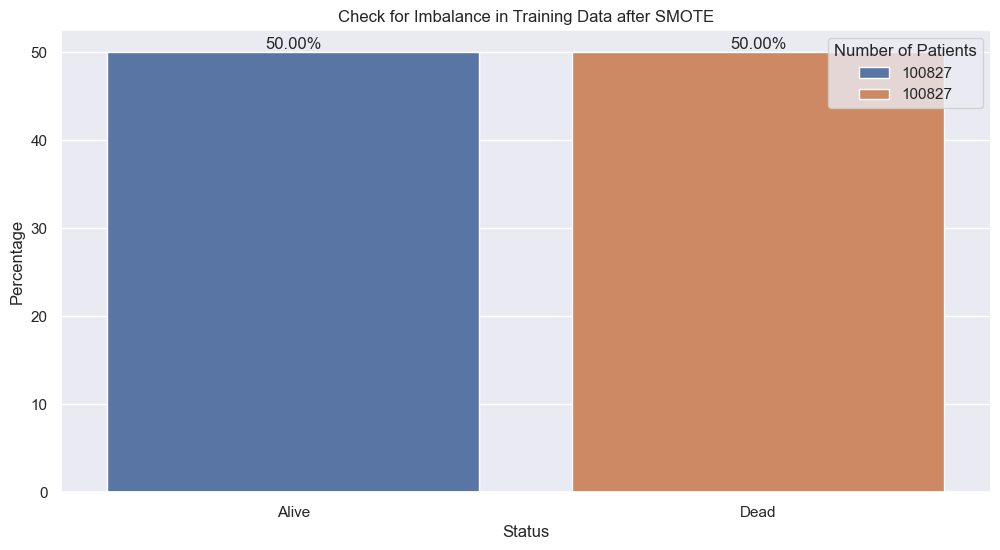

In [43]:
plt.figure(figsize=(12, 6))

ax = sns.countplot(x=y_train, stat="percent", hue=y_train, legend=False)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f%%")

plt.title("Check for Imbalance in Training Data after SMOTE")
plt.xticks(ticks=[0, 1], labels=["Alive", "Dead"])
plt.xlabel("Status")
plt.ylabel("Percentage")
plt.legend(y_train.value_counts(), title="Number of Patients")
plt.show()

## Logistic Regression
This code performs logistic regression using the `LogisticRegression` model from the `scikit-learn` library. It measures the training and prediction times, evaluates the model's performance using the F1 score, and outputs the model's coefficients and intercept.

In [44]:
lr = LogisticRegression(random_state=42, n_jobs=-1, max_iter=1000)
lr_train_time = time.time()
lr.fit(X_train, y_train)
lr_train_time = time.time() - lr_train_time

lr_pred_time = time.time()
y_pred = lr.predict(X_test)
lr_pred_time = time.time() - lr_pred_time

lr_f1_score = f1_score(y_test, y_pred, average="weighted")

print(
    f"Logistic Regression Classification Report:\nTraining Time: {lr_train_time:.3f}s | Prediction Time: {lr_pred_time:.3f}s\n"
)
print(classification_report(y_test, y_pred))

print("-" * 50)

print(f"\nCoefficients: {lr.coef_}\n")
print(f"Intercept: {lr.intercept_}")

Logistic Regression Classification Report:
Training Time: 2.854s | Prediction Time: 0.005s

              precision    recall  f1-score   support

       False       0.89      0.74      0.81     25366
        True       0.51      0.75      0.60      9213

    accuracy                           0.74     34579
   macro avg       0.70      0.74      0.71     34579
weighted avg       0.79      0.74      0.75     34579

--------------------------------------------------

Coefficients: [[ 0.07216334 -0.04198773 -0.37405278 -1.50301458  1.72156556  0.68097089
   0.47600206 -1.63106087  0.0892259  -0.40231274 -1.19510948 -0.42749527
  -0.04585407 -0.28845918 -0.50261269 -0.10983146  0.04904913 -0.5849994
   0.74775537 -0.5568158 ]]

Intercept: [-0.23989537]


This bar plot provides a visual representation of the logistic regression model's coefficients, helping to identify which features have the most significant impact on the model's predictions.

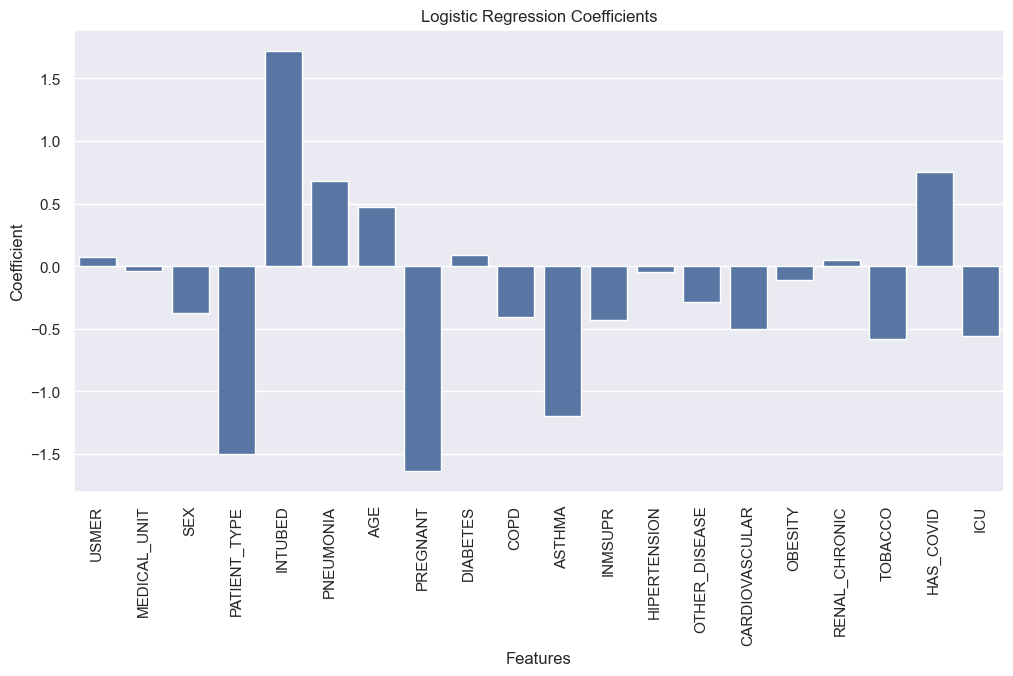

In [45]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=X_train.columns, y=lr.coef_[0])
plt.title("Logistic Regression Coefficients")
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.xticks(rotation=90)
plt.show()

This heatmap provides a visual representation of the confusion matrix, helping to understand the logistic regression model's performance in terms of true positives, true negatives, false positives, and false negatives.

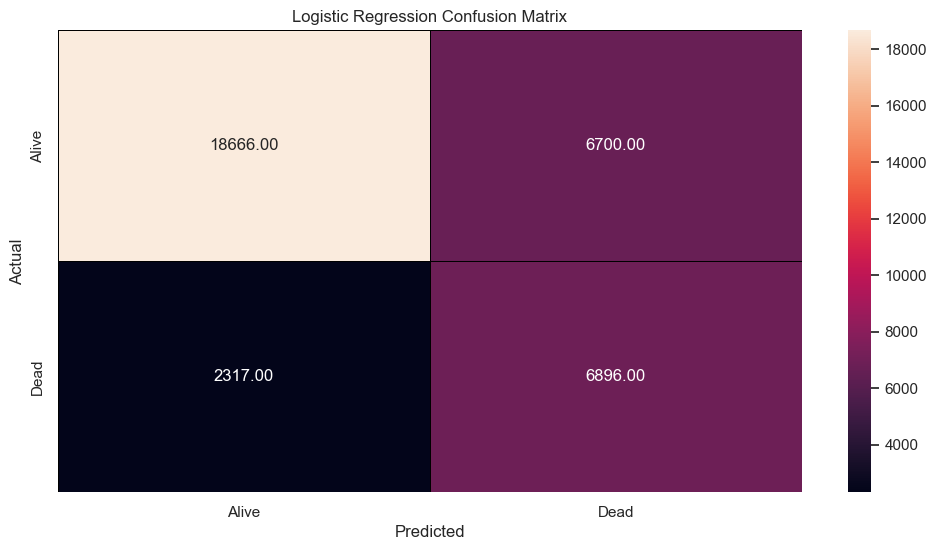

In [46]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", linewidths=0.5, linecolor="black")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.xticks(ticks=[0.5, 1.5], labels=["Alive", "Dead"])
plt.yticks(ticks=[0.5, 1.5], labels=["Alive", "Dead"])
plt.ylabel("Actual")
plt.show()

## K-Nearest Neighbors Classifier
This code performs K-Nearest Neighbors (KNN) classification using the `KNeighborsClassifier` model from the `scikit-learn` library. It measures the training and prediction times, evaluates the model's performance using the F1 score, and outputs the model's parameters.

In [47]:
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_train_time = time.time()
knn.fit(X_train, y_train)
knn_train_time = time.time() - knn_train_time

knn_pred_time = time.time()
y_pred = knn.predict(X_test)
knn_pred_time = time.time() - knn_pred_time

knn_f1_score = f1_score(y_test, y_pred, average="weighted")

print(
    f"K-Nearest Neighbors Classification Report:\nTraining Time: {knn_train_time:.3f}s | Prediction Time: {knn_pred_time:.3f}s\n"
)
print(classification_report(y_test, y_pred))

print("-" * 50)

print(f"\n{knn.get_params()}")

K-Nearest Neighbors Classification Report:
Training Time: 0.037s | Prediction Time: 4.685s

              precision    recall  f1-score   support

       False       0.87      0.71      0.78     25366
        True       0.47      0.70      0.56      9213

    accuracy                           0.71     34579
   macro avg       0.67      0.71      0.67     34579
weighted avg       0.76      0.71      0.72     34579

--------------------------------------------------

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


This code creates a line plot to visualize the weighted F1 scores of a K-Nearest Neighbors (KNN) classifier as the number of neighbors (k) varies from 1 to 10. This helps in understanding how the choice of k affects the model's performance.

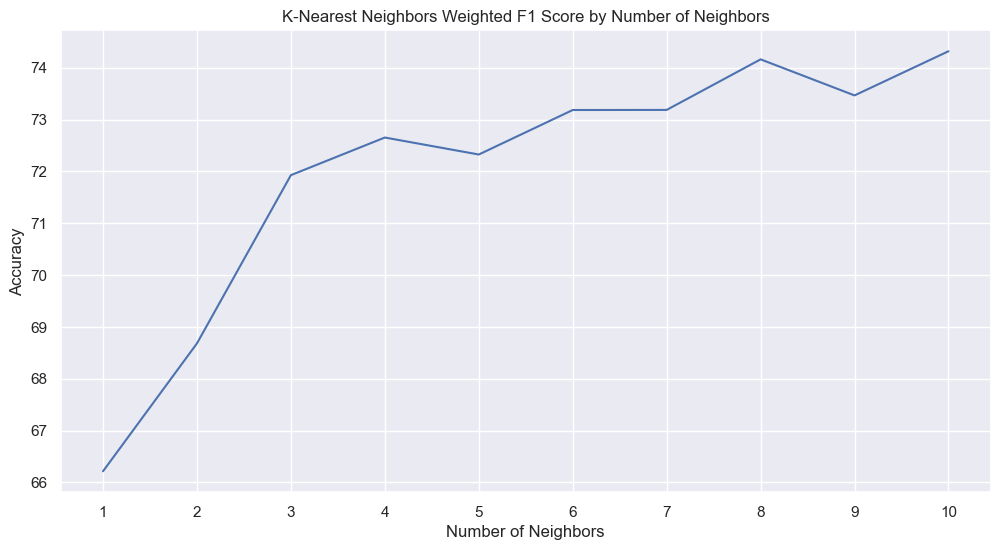

In [48]:
plt.figure(figsize=(12, 6))

k = 10
f1_scores = []

for i in range(1, k + 1):
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    f1_scores.append(f1_score(y_test, y_pred, average="weighted") * 100)

ax = sns.lineplot(x=range(1, k + 1), y=f1_scores)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))

plt.title("K-Nearest Neighbors Weighted F1 Score by Number of Neighbors")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

This heatmap provides a visual representation of the confusion matrix, helping to understand the K-Nearest Neighbors model's performance in terms of true positives, true negatives, false positives, and false negatives.

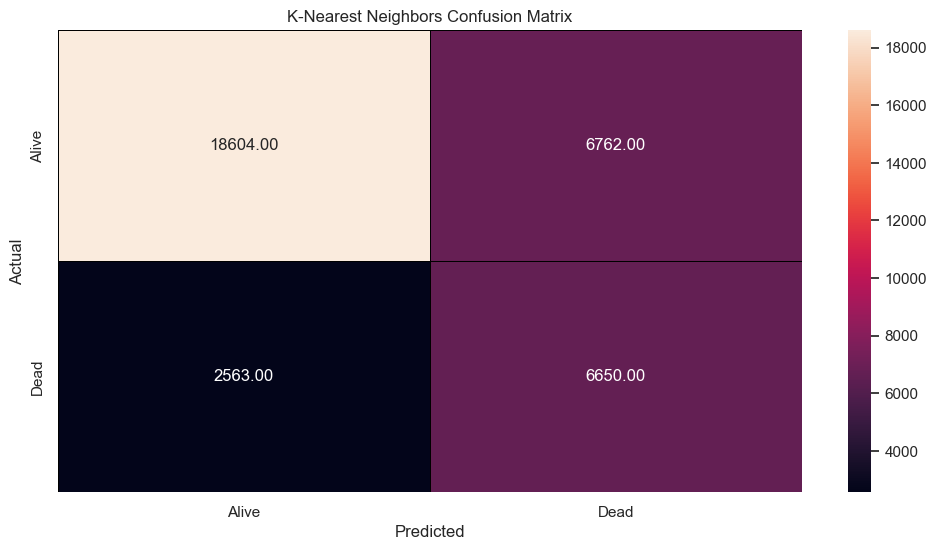

In [49]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", linewidths=0.5, linecolor="black")
plt.title("K-Nearest Neighbors Confusion Matrix")
plt.xlabel("Predicted")
plt.xticks(ticks=[0.5, 1.5], labels=["Alive", "Dead"])
plt.yticks(ticks=[0.5, 1.5], labels=["Alive", "Dead"])
plt.ylabel("Actual")
plt.show()

## Gaussian Naive Bayes
This code performs Gaussian Naive Bayes classification using the `GaussianNB` model from the `scikit-learn` library. It measures the training and prediction times, evaluates the model's performance using the F1 score, and outputs the model's parameters (mean and variance of each feature for each class).

In [50]:
nb = GaussianNB()
nb_train_time = time.time()
nb.fit(X_train, y_train)
nb_train_time = time.time() - nb_train_time

nb_pred_time = time.time()
y_pred = nb.predict(X_test)
nb_pred_time = time.time() - nb_pred_time

nb_f1_score = f1_score(y_test, y_pred, average="weighted")

print(
    f"Gaussian Naive Bayes Classification Report:\nTraining Time: {nb_train_time:.3f}s | Prediction Time: {nb_pred_time:.3f}s\n"
)
print(classification_report(y_test, y_pred))

print("-" * 50)

print(f"\nTheta: {nb.theta_}\n")
print(f"Variances: {nb.var_}")

Gaussian Naive Bayes Classification Report:
Training Time: 0.090s | Prediction Time: 0.013s

              precision    recall  f1-score   support

       False       0.90      0.64      0.75     25366
        True       0.45      0.81      0.58      9213

    accuracy                           0.69     34579
   macro avg       0.68      0.72      0.66     34579
weighted avg       0.78      0.69      0.70     34579

--------------------------------------------------

Theta: [[4.47152053e-01 7.74618902e+00 4.90622551e-01 5.36483283e-01
  4.77947375e-02 3.29296716e-01 4.90715059e-01 1.88937487e-02
  3.15153679e-01 7.72312972e-02 9.98442877e-02 7.32442699e-02
  3.86215994e-01 1.07401787e-01 1.00846004e-01 3.08052407e-01
  8.64550170e-02 1.76926815e-01 4.34576056e-01 5.53919089e-02]
 [5.16359705e-01 7.03321531e+00 3.89240977e-01 1.09474645e-01
  3.45314251e-01 6.77080544e-01 1.14208636e+00 1.29925516e-03
  4.09939798e-01 6.58652940e-02 1.83284239e-02 3.66370119e-02
  4.66958255e-01 7.42459

This heatmap provides a visual representation of the confusion matrix, helping to understand the Gaussian Naive Bayes model's performance in terms of true positives, true negatives, false positives, and false negatives.

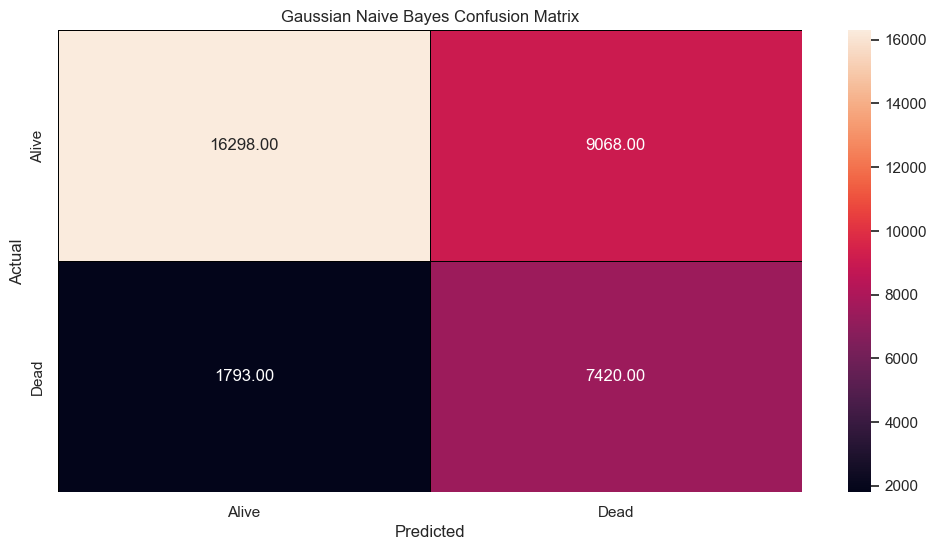

In [51]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", linewidths=0.5, linecolor="black")
plt.title("Gaussian Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.xticks(ticks=[0.5, 1.5], labels=["Alive", "Dead"])
plt.yticks(ticks=[0.5, 1.5], labels=["Alive", "Dead"])
plt.ylabel("Actual")
plt.show()

## Decision Tree Classifier
This code performs Decision Tree classification using the `DecisionTreeClassifier` from the `scikit-learn` library. It measures the training and prediction times, evaluates the model's performance using the F1 score, and outputs the feature importances.

In [52]:
dt = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_train_time = time.time()
dt.fit(X_train, y_train)
dt_train_time = time.time() - dt_train_time

dt_pred_time = time.time()
y_pred = dt.predict(X_test)
dt_pred_time = time.time() - dt_pred_time

dt_f1_score = f1_score(y_test, y_pred, average="weighted")

print(
    f"Decision Tree Classification Report:\nTraining Time: {dt_train_time:.3f}s | Prediction Time: {dt_pred_time:.3f}s\n"
)
print(classification_report(y_test, y_pred))

print("-" * 50)

print(f"Feature Importances: {dt.feature_importances_}")

Decision Tree Classification Report:
Training Time: 0.305s | Prediction Time: 0.006s

              precision    recall  f1-score   support

       False       0.90      0.71      0.80     25366
        True       0.50      0.78      0.61      9213

    accuracy                           0.73     34579
   macro avg       0.70      0.75      0.70     34579
weighted avg       0.79      0.73      0.75     34579

--------------------------------------------------
Feature Importances: [0.         0.01919425 0.00065189 0.58238723 0.15080527 0.06015164
 0.12144039 0.         0.         0.         0.00217597 0.
 0.         0.         0.         0.         0.         0.
 0.06258403 0.00060933]


This bar plot provides a visual representation of the importance of each feature in the Decision Tree model, making it easier to identify which features are the most influential in predicting the target variable.

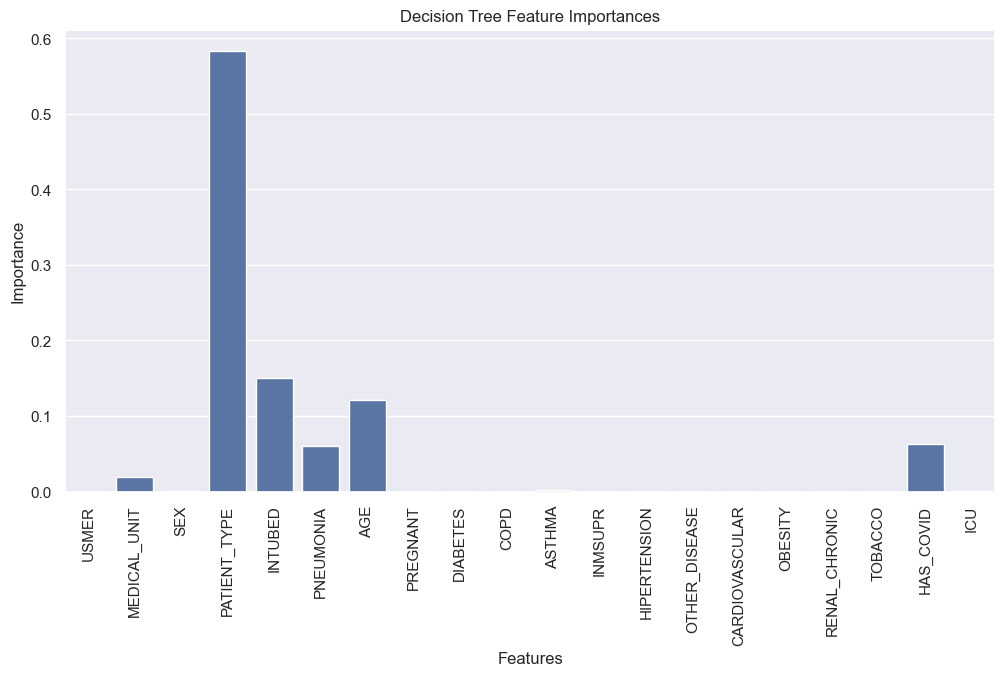

In [53]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(x=X_train.columns, y=dt.feature_importances_)
plt.title("Decision Tree Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.show()

In [54]:
from sklearn.tree import export_graphviz
import pydot


export_graphviz(
    dt, out_file="tree.dot", feature_names=X_train.columns, rounded=True, filled=True
)

(graph,) = pydot.graph_from_dot_file("tree.dot")
graph.write_png("tree.png")

This heatmap provides a visual representation of the confusion matrix, helping to understand the Decision Tree model's performance in terms of true positives, true negatives, false positives, and false negatives.

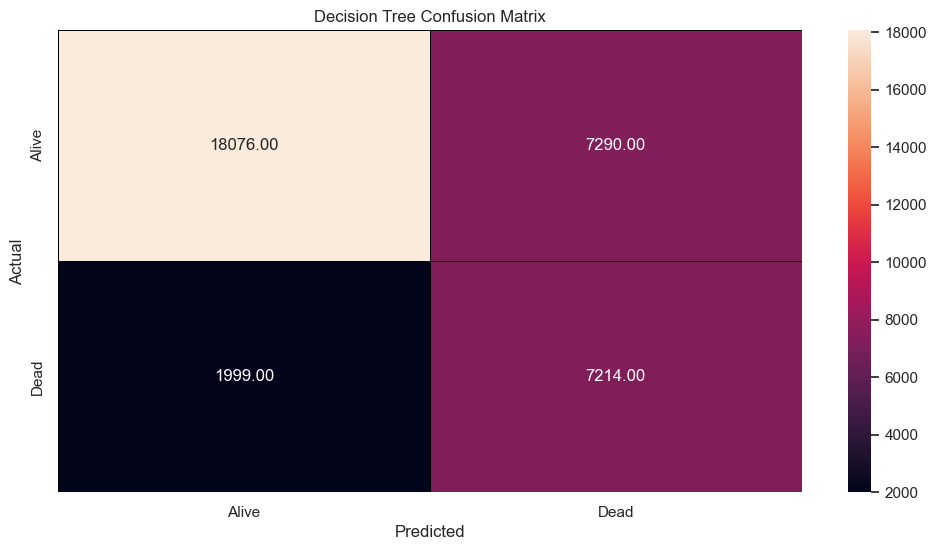

In [55]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", linewidths=0.5, linecolor="black")
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.xticks(ticks=[0.5, 1.5], labels=["Alive", "Dead"])
plt.yticks(ticks=[0.5, 1.5], labels=["Alive", "Dead"])
plt.ylabel("Actual")
plt.show()

## Random Forest Classifier
This code performs Random Forest classification using the `RandomForestClassifier` from the `scikit-learn` library. It measures the training and prediction times, evaluates the model's performance using the F1 score, and outputs the feature importances.

In [56]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5)
rf_train_time = time.time()
rf.fit(X_train, y_train)
rf_train_time = time.time() - rf_train_time

rf_pred_time = time.time()
y_pred = rf.predict(X_test)
rf_pred_time = time.time() - rf_pred_time

rf_f1_score = f1_score(y_test, y_pred, average="weighted")

print(
    f"Random Forest Classification Report:\nTraining Time: {rf_train_time:.3f}s | Prediction Time: {rf_pred_time:.3f}s\n"
)
print(classification_report(y_test, y_pred))

print("-" * 50)

print(f"Feature Importances: {rf.feature_importances_}")

Random Forest Classification Report:
Training Time: 1.884s | Prediction Time: 0.032s

              precision    recall  f1-score   support

       False       0.92      0.68      0.78     25366
        True       0.48      0.83      0.61      9213

    accuracy                           0.72     34579
   macro avg       0.70      0.75      0.69     34579
weighted avg       0.80      0.72      0.73     34579

--------------------------------------------------
Feature Importances: [1.04814167e-03 3.49622129e-02 7.80305170e-03 3.63355021e-01
 1.72395584e-01 1.93576222e-01 1.18306648e-01 4.29278636e-03
 3.31043229e-03 5.24178467e-04 2.18323894e-02 1.44112870e-03
 1.00315320e-03 9.53809201e-04 1.23071218e-03 7.11735106e-04
 1.57463664e-04 5.40714356e-03 6.12163791e-02 6.47180693e-03]


This bar plot provides a visual representation of the importance of each feature in the Random Forest model, making it easier to identify which features are the most influential in predicting the target variable.

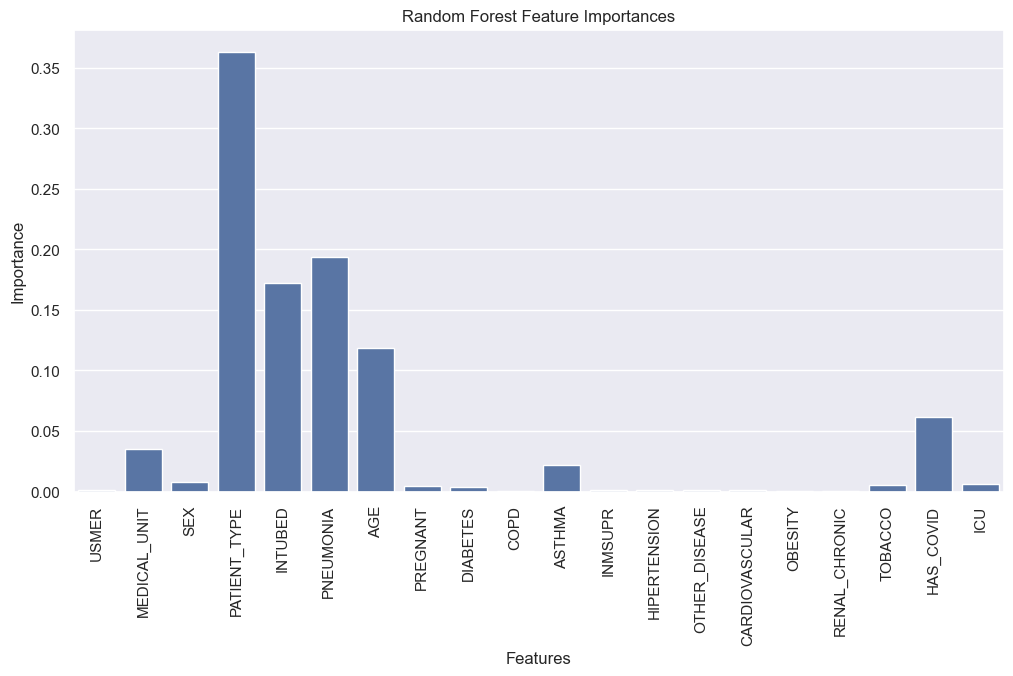

In [57]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(x=X_train.columns, y=rf.feature_importances_)

plt.title("Random Forest Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.show()

This heatmap provides a visual representation of the confusion matrix, helping to understand the Random Forest model's performance in terms of true positives, true negatives, false positives, and false negatives.

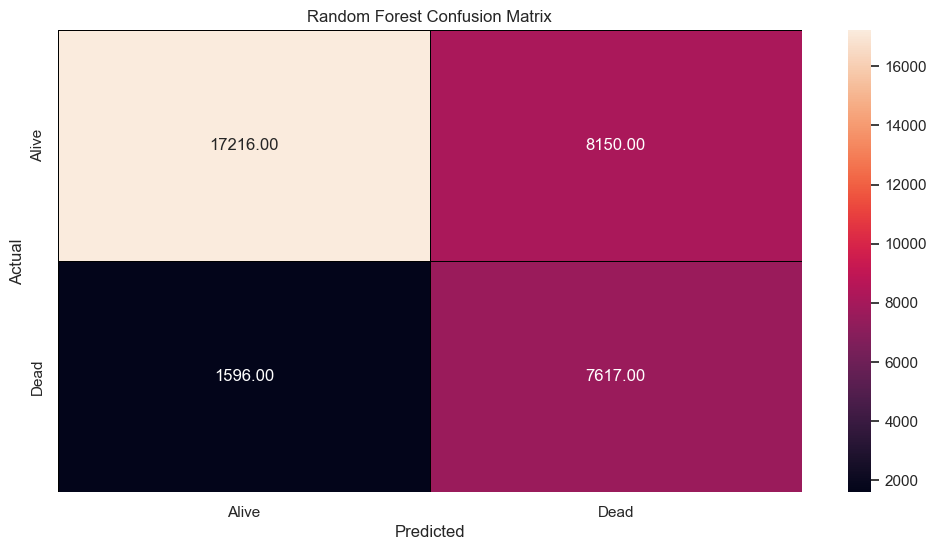

In [58]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", linewidths=0.5, linecolor="black")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.xticks(ticks=[0.5, 1.5], labels=["Alive", "Dead"])
plt.yticks(ticks=[0.5, 1.5], labels=["Alive", "Dead"])
plt.ylabel("Actual")
plt.show()

## Gradient Boosting Classifier

This code performs Gradient Boosting classification using the `GradientBoostingClassifier` from the `scikit-learn` library. It measures the training and prediction times, evaluates the model's performance using the F1 score, and outputs the feature importances.

In [59]:
gb = GradientBoostingClassifier(random_state=42)
gb_train_time = time.time()
gb.fit(X_train, y_train)
gb_train_time = time.time() - gb_train_time

gb_pred_time = time.time()
y_pred = gb.predict(X_test)
gb_pred_time = time.time() - gb_pred_time

gb_f1_score = f1_score(y_test, y_pred, average="weighted")

print(
    f"Gradient Boosting Classification Report:\nTraining Time: {gb_train_time:.3f}s | Prediction Time: {gb_pred_time:.3f}s\n"
)
print(classification_report(y_test, y_pred))

print("-" * 50)

print(f"Feature Importances: {gb.feature_importances_}")

Gradient Boosting Classification Report:
Training Time: 14.968s | Prediction Time: 0.049s

              precision    recall  f1-score   support

       False       0.90      0.74      0.81     25366
        True       0.52      0.78      0.63      9213

    accuracy                           0.75     34579
   macro avg       0.71      0.76      0.72     34579
weighted avg       0.80      0.75      0.76     34579

--------------------------------------------------
Feature Importances: [1.76222045e-04 5.20507461e-02 8.39482462e-03 4.72217380e-01
 1.31453241e-01 7.69246203e-02 1.55360506e-01 1.66749427e-03
 0.00000000e+00 4.04719524e-03 1.52017630e-02 3.24349096e-03
 1.73203927e-04 2.61810672e-03 5.52742112e-03 1.41148220e-03
 2.29641386e-04 9.10001875e-03 5.63727454e-02 3.82989624e-03]


This bar plot provides a visual representation of the importance of each feature in the Gradient Boosting model, making it easier to identify which features are the most influential in predicting the target variable.

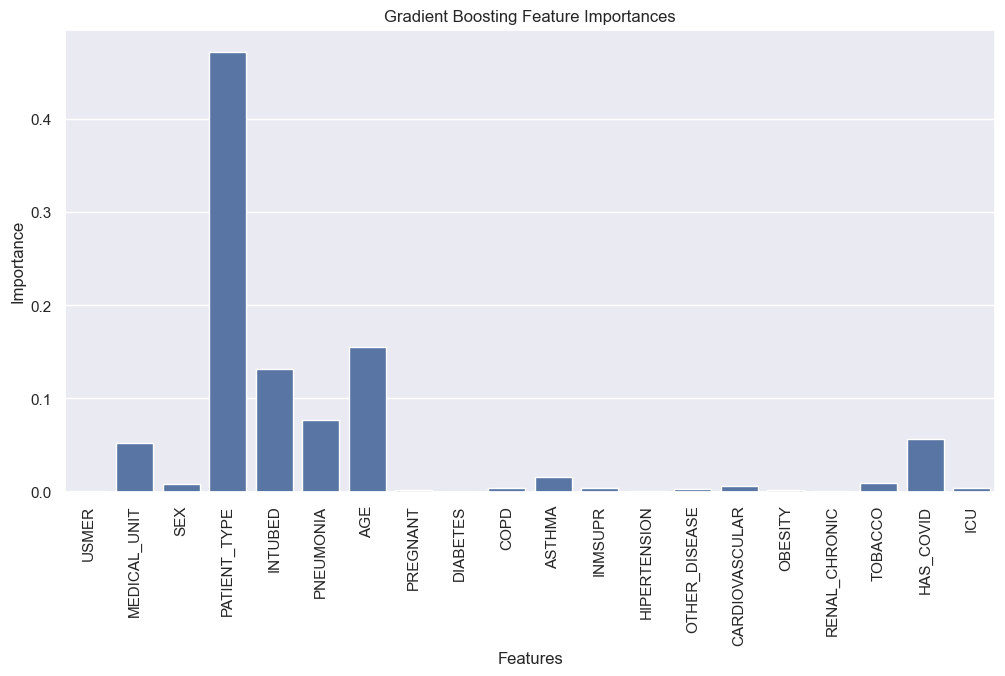

In [60]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(x=X_train.columns, y=gb.feature_importances_)
plt.title("Gradient Boosting Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.show()

This heatmap provides a visual representation of the confusion matrix, helping to understand the Gradient Boosting model's performance in terms of true positives, true negatives, false positives, and false negatives.

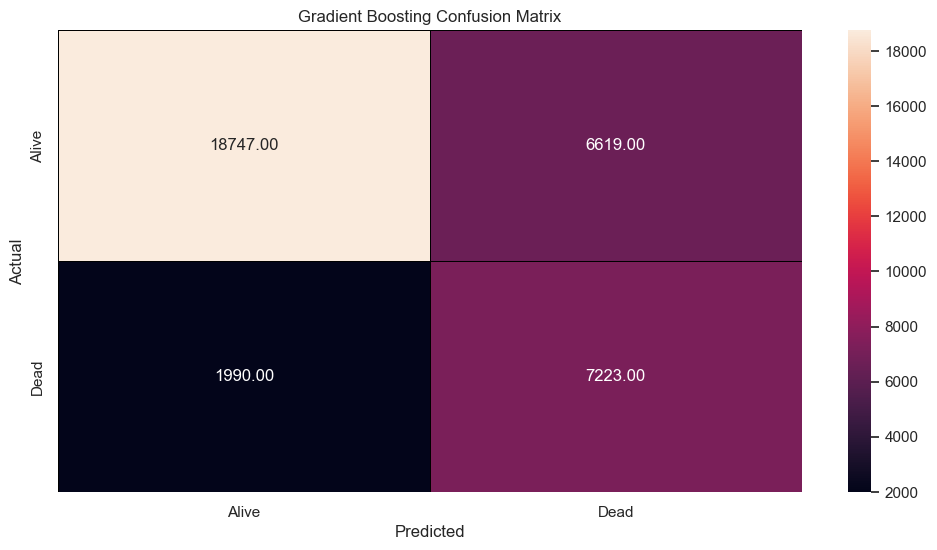

In [61]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", linewidths=0.5, linecolor="black")
plt.title("Gradient Boosting Confusion Matrix")
plt.xlabel("Predicted")
plt.xticks(ticks=[0.5, 1.5], labels=["Alive", "Dead"])
plt.yticks(ticks=[0.5, 1.5], labels=["Alive", "Dead"])
plt.ylabel("Actual")
plt.show()

## Multilayer Perceptron (MLP) Classifier
This code performs Multilayer Perceptron (MLP) classification using the `MLPClassifier` from the `scikit-learn` library. It measures the training and prediction times, evaluates the model's performance using the F1 score, and outputs the classification report. It initializes an MLP classifier with two hidden layers containing 100 and 70 neurons respectively, and a maximum number of iterations set to 1000.

In [62]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), random_state=42, max_iter=1000)
mlp_train_time = time.time()
mlp.fit(X_train, y_train)
mlp_train_time = time.time() - mlp_train_time

mlp_pred_time = time.time()
y_pred = mlp.predict(X_test)
mlp_pred_time = time.time() - mlp_pred_time

mlp_f1_score = f1_score(y_test, y_pred, average="weighted")

print(
    f"MLP Classification Report:\nTraining Time: {mlp_train_time:.3f}s | Prediction Time: {mlp_pred_time:.3f}s\n"
)
print(classification_report(y_test, y_pred))

MLP Classification Report:
Training Time: 64.150s | Prediction Time: 0.025s

              precision    recall  f1-score   support

       False       0.92      0.71      0.80     25366
        True       0.50      0.82      0.63      9213

    accuracy                           0.74     34579
   macro avg       0.71      0.77      0.71     34579
weighted avg       0.81      0.74      0.75     34579



This heatmap provides a visual representation of the confusion matrix, helping to understand the MLP model's performance in terms of true positives, true negatives, false positives, and false negatives.

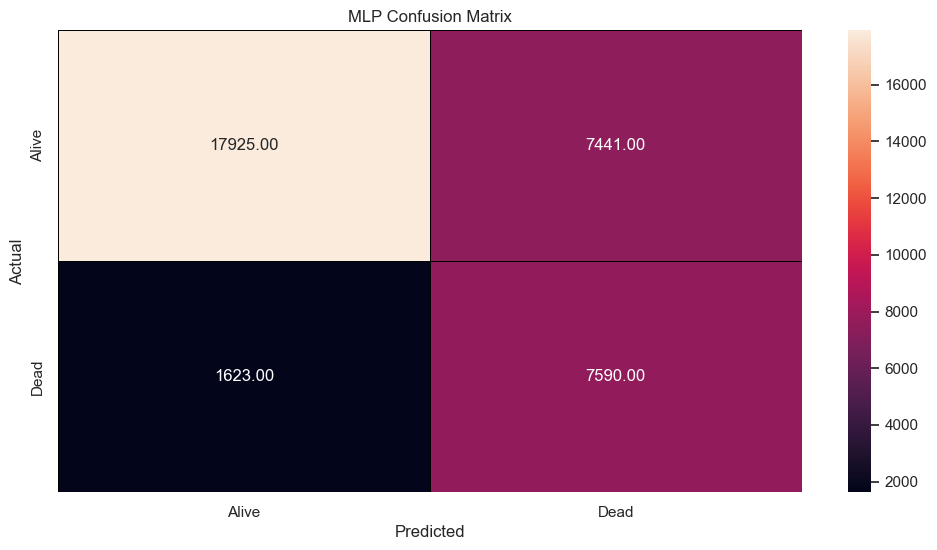

In [63]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", linewidths=0.5, linecolor="black")
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.xticks(ticks=[0.5, 1.5], labels=["Alive", "Dead"])
plt.yticks(ticks=[0.5, 1.5], labels=["Alive", "Dead"])
plt.ylabel("Actual")
plt.show()

## Linear Support Vector Classifier
This code performs classification using the `LinearSVC` from the `scikit-learn` library. It measures the training and prediction times, evaluates the model's performance using the F1 score, and outputs the classification report.

In [64]:
svc = LinearSVC(random_state=42)
svc_train_time = time.time()
svc.fit(X_train, y_train)
svc_train_time = time.time() - svc_train_time

svc_pred_time = time.time()
y_pred = svc.predict(X_test)
svc_pred_time = time.time() - svc_pred_time

svc_f1_score = f1_score(y_test, y_pred, average="weighted")

print(
    f"Linear SVC Classification Report:\nTraining Time: {svc_train_time:.3f}s | Prediction Time: {svc_pred_time:.3f}s\n"
)
print(classification_report(y_test, y_pred))

Linear SVC Classification Report:
Training Time: 0.536s | Prediction Time: 0.006s

              precision    recall  f1-score   support

       False       0.89      0.72      0.80     25366
        True       0.50      0.76      0.60      9213

    accuracy                           0.73     34579
   macro avg       0.70      0.74      0.70     34579
weighted avg       0.79      0.73      0.75     34579



This heatmap provides a visual representation of the confusion matrix, helping to understand the Linear SVC model's performance in terms of true positives, true negatives, false positives, and false negatives.

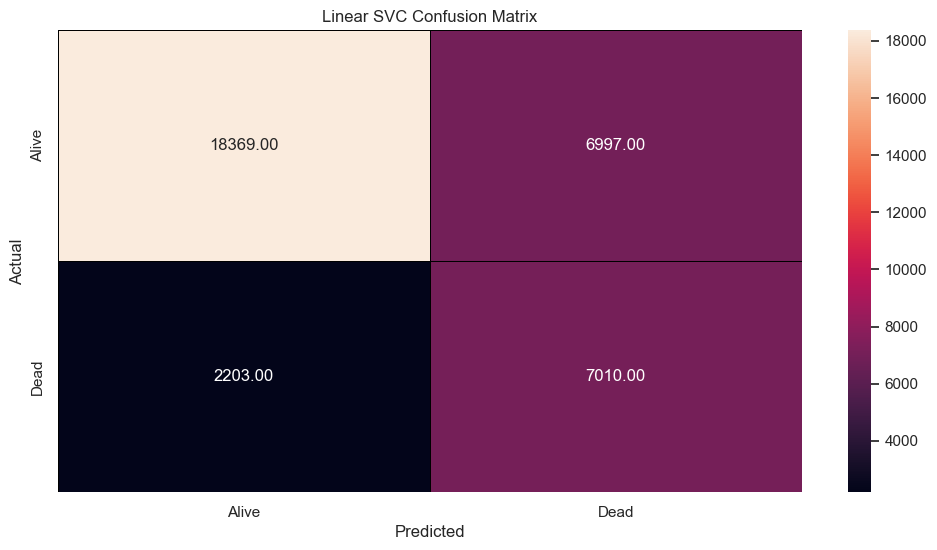

In [65]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", linewidths=0.5, linecolor="black")
plt.title("Linear SVC Confusion Matrix")
plt.xlabel("Predicted")
plt.xticks(ticks=[0.5, 1.5], labels=["Alive", "Dead"])
plt.yticks(ticks=[0.5, 1.5], labels=["Alive", "Dead"])
plt.ylabel("Actual")
plt.show()

## Comparative F1 Scores of Various Classification Models
This code creates a bar plot to visualize the F1 scores of different classification models. The plot helps compare the performance of various models based on their F1 scores

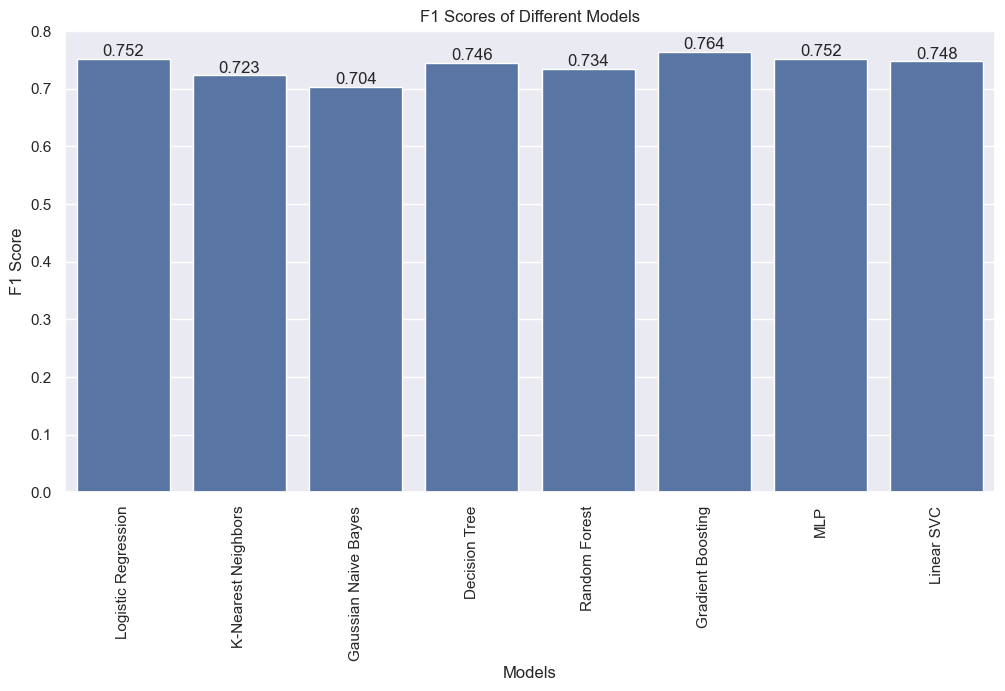

In [66]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(
    x=[
        "Logistic Regression",
        "K-Nearest Neighbors",
        "Gaussian Naive Bayes",
        "Decision Tree",
        "Random Forest",
        "Gradient Boosting",
        "MLP",
        "Linear SVC",
    ],
    y=[
        lr_f1_score,
        knn_f1_score,
        nb_f1_score,
        dt_f1_score,
        rf_f1_score,
        gb_f1_score,
        mlp_f1_score,
        svc_f1_score,
    ],
)

ax.bar_label(ax.containers[0], fmt="%.3f")

plt.title("F1 Scores of Different Models")
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.xticks(rotation=90)
plt.show()

## Comparative Training Times of Various Classification Models
This bar plot provides a visual representation of the training times for different classification models, making it easier to compare their time efficiency and identify which model trains the fastest.

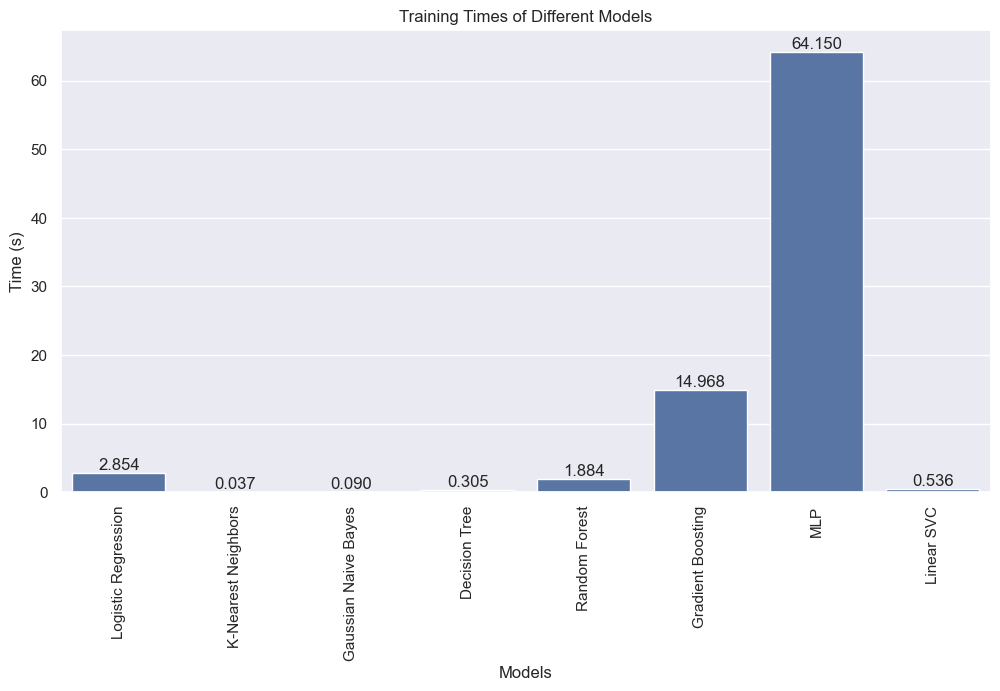

In [67]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(
    x=[
        "Logistic Regression",
        "K-Nearest Neighbors",
        "Gaussian Naive Bayes",
        "Decision Tree",
        "Random Forest",
        "Gradient Boosting",
        "MLP",
        "Linear SVC",
    ],
    y=[
        lr_train_time,
        knn_train_time,
        nb_train_time,
        dt_train_time,
        rf_train_time,
        gb_train_time,
        mlp_train_time,
        svc_train_time,
    ],
)

ax.bar_label(ax.containers[0], fmt="%.3f")

plt.title("Training Times of Different Models")
plt.xlabel("Models")
plt.ylabel("Time (s)")
plt.xticks(rotation=90)
plt.show()

## Comparative Prediction Times of Various Classification Models
This bar plot provides a visual representation of the prediction times for different classification models, making it easier to compare their time efficiency and identify which model makes predictions the fastest.

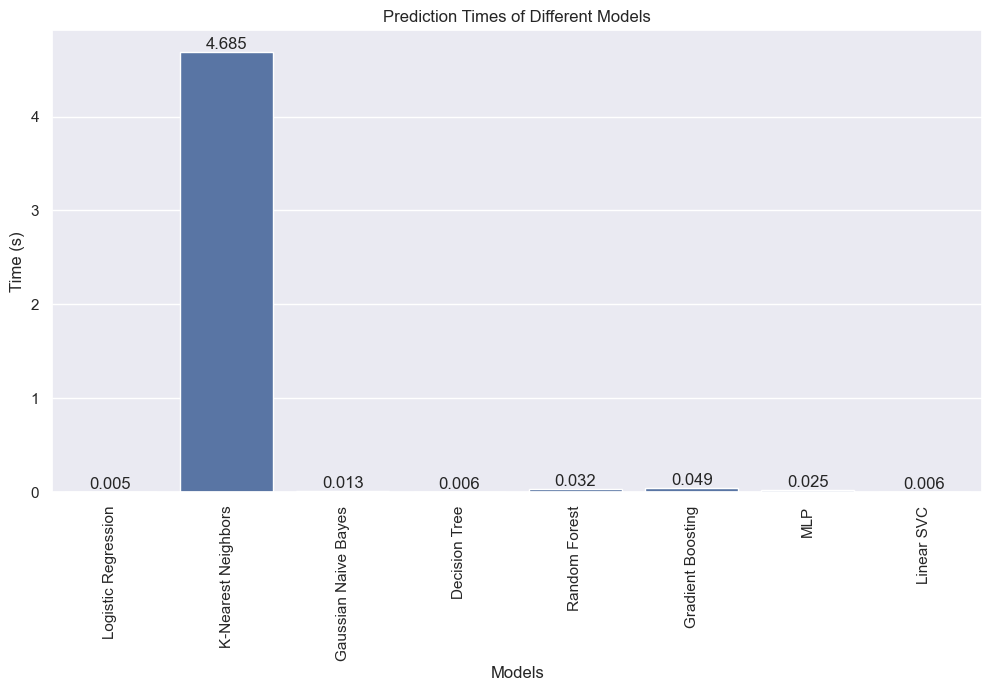

In [68]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(
    x=[
        "Logistic Regression",
        "K-Nearest Neighbors",
        "Gaussian Naive Bayes",
        "Decision Tree",
        "Random Forest",
        "Gradient Boosting",
        "MLP",
        "Linear SVC",
    ],
    y=[
        lr_pred_time,
        knn_pred_time,
        nb_pred_time,
        dt_pred_time,
        rf_pred_time,
        gb_pred_time,
        mlp_pred_time,
        svc_pred_time,
    ],
)

ax.bar_label(ax.containers[0], fmt="%.3f")

plt.title("Prediction Times of Different Models")
plt.xlabel("Models")
plt.ylabel("Time (s)")
plt.xticks(rotation=90)
plt.show()